In [1]:
## To Do


# Should data be log normalised following a +1/ This will remove negative values after log norm.

In [2]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openpyxl import load_workbook

from scipy import stats as stats
from copy import copy as copy

from IPython.display import clear_output

import time

In [3]:
titleFont = {'fontsize': 32}
# ,
#  'fontweight': rcParams['axes.titleweight'],
#  'color': rcParams['axes.titlecolor'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': loc}

labelFont = {'fontsize': 20}
# ,
#  'fontweight': rcParams['axes.titleweight'],
#  'color': rcParams['axes.titlecolor'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': loc}



In [4]:
colourList = [
    (230, 159,   0, 1),
    ( 86, 180, 233, 1),
    (  0, 158, 115, 1),
    (240, 228,  66, 1),
    (  0, 114, 178, 1),
    (213,  94,   0, 1),
    (204, 121, 167, 1),
    (  0,   0,   0, 1)]

colourList = [
    (0.90, 0.60, 0.00, 1),
    (0.35, 0.70, 0.90, 1),
    (0.00, 0.60, 0.50, 1),
    (0.95, 0.90, 0.25, 1),
    (0.00, 0.45, 0.70, 1),
    (0.80, 0.40, 0.00, 1),
    (0.80, 0.60, 0.70, 1),
    (  0,   0,   0, 1)]


# namedColourList = ['orange','skyblue','seagreen','yellow','blue','indianred','violet','black']
namedColourList = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [5]:
class master_data:
    def __init__(self, dataPath):
        ### import data from excel workbook
        
        self.wb = load_workbook(dataPath)
        self.ws = self.wb['Exported dataset']
        self.values = [[y.value for y in x] for x in self.ws[self.ws.calculate_dimension()]]

        self.dropData = False
        
        
        ### Convert nested list to a pandas dataFrame and extract expression data with labels
    def get_data(self):
        df = pd.DataFrame(self.values)
        col3 = df.iloc[:,3].tolist()
        self.targIdx = col3.index('Target name (display name)') + 1

        
        rowLabels = df.iloc[self.targIdx:,3]
        # rowLabels = [x.split(' (')[0] for x in rowLabels.values]
        rowLabels = dict(zip([x for x in range(self.targIdx,self.targIdx+len(rowLabels))],rowLabels))
        rowLabels

        colLabels = df.iloc[0,4:]
        colLabels = [x.replace(' | ','_') for x in colLabels.values]
        colLabels = dict(zip([x for x in range(4,4+len(colLabels))],colLabels))
        colLabels

        self.data = df.iloc[self.targIdx:,4:].astype(np.float32)
        self.data.rename(index=rowLabels,columns=colLabels, inplace=True)

        
        self.sampleInfo = pd.DataFrame(df.iloc[0:self.targIdx-1,4:])
        self.sampleInfo.rename(index=df.iloc[0:self.targIdx-1,0], columns=colLabels, inplace=True)
        print('sampleInfo.shape')
        print(self.sampleInfo.shape)
        
        
        print('data.shape')
        print(self.data.shape)

        self.dataOrig = self.data.copy()
        # Log transform data for QC and analysis steps
        self.dataLog1 = np.log2(self.data+1)
        
        
        self.probeClass = df.iloc[self.targIdx:,2]      ### Index needs updating here also
        self.probeClass.rename(index=rowLabels, inplace=True)
        self.probeClass.rename(index='ProbeClass', inplace=True)
        self.probeClassDict = {
            'Positive': 'A',
            'Negative': 'B',
            'Control': 'C',
            'Endogenous': 'E'
        }
        return self.dataLog1.copy(), self.sampleInfo.copy()
    
    def get_descriptors(self):
        ### Extract descriptions for each sample
        nuclei = sampleInfo.loc['AOI nuclei count']
        surfArea = sampleInfo.loc['AOI surface area']

        print(sampleInfo.shape)
#         sampleInfo
        
    def add_class_mean(self, df):
        ## Add column to data with mean values for each probe (row)
        mean = df.mean(axis = 1)
        df = df.assign(mean=mean.values)

        ## Add column to data with probe class for each probe
        df = df.assign(probeClass=[self.probeClassDict[v] for v in self.probeClass.values])

        ### Extract lists of controls and their values
        self.posCTLs = self.probeClass.index[self.probeClass== 'Positive'].tolist()
        self.negCTLs = self.probeClass.index[self.probeClass== 'Negative'].tolist()
        self.IgCTLs = copy(self.negCTLs)
        try:
            self.IgCTLs.remove('HYB-NEG')
        except ValueError:
            pass
        self.HK = self.probeClass.index[self.probeClass== 'Control'].tolist()
        self.endog = self.probeClass.index[self.probeClass== 'Endogenous'].tolist()

        print('Positive Control count:\t{:d}, {}'.format(len(self.posCTLs), self.posCTLs))
        print('Nagative Control count:\t{:d}, {}'.format(len(self.negCTLs), self.negCTLs))
        print('Ig Control count:\t{:d}, {}'.format(len(self.IgCTLs), self.IgCTLs))
        print('HK Control count:\t{:d}, {}'.format(len(self.HK), self.HK))
        print('Endogenous probe count:\t{:d}, {}'.format(len(self.endog), self.endog))

        return df.copy(), self.sampleInfo.copy()

    def drop_AOIs(self, includes, writeOrig=False):
        dropAOIs = [x for x in list(self.data.columns) if includes in x]
        self.dataLog1.drop(labels=dropAOIs, axis=1, inplace=True)
        
        if writeOrig:
            self.dataOrig = self.dataOrig.drop(labels=dropAOIs, axis=1, inplace=True)
        
        self.sampleInfo = self.sampleInfo.drop(labels=dropAOIs, axis=1)
        
        
        return self.dataLog1.copy(), self.sampleInfo.copy()
        
    def set_threshold(self, threshold):
        self.threshold = threshold
        
        
        # ToDo: Check that all values in master data are also included in threshold dataFrame
        # ToDo: Convert threshold data to 0/1 data if needed
        
    
#     def drop_sample(self):
#         try:
#             assert type(labels) == list
#         except:
#             print('labels need to be a list')
#             return False

#         if not self.dropData:
#             self,.dropData = self.dataLog1
            
#         self.dropData.drop((labels=labels, axis=1))
#         return self.dropData
        
    def drop_probes(self, labels):
        try:
            assert type(labels) == list
        except:
            print('labels need to be a list')
            return False
            
        if not self.dropData:
            self.dropData = self.dataLog1

        self.dropData.drop(labels=labels)
        
        return self.dropData.copy()
        
    def ERCC_norm(self):
        if not self.dropData:
            self.dropData = self.dataLog1
            
        try:
            self.dropData = self.dropData.drop(labels=['mean'], axis=1)
        except:
            pass
        try:
            self.dropData = self.dropData.drop(labels=['probeClass'], axis=1)
        except:
            pass
            
            
        # ERCC normalisation. 
        # Divide by individual HYB-POS values, then scale data using the geometric mean of all HYB-POS values. subtract in log space is same as divide in normal space. Add in log space is same as multiply in normal space
        self.ERCCData = self.dropData - self.dropData.loc['HYB-POS'] + np.mean(self.dropData.loc['HYB-POS'])

        #ToDo: set below threshold values to 0
        self.ERCCData = self.ERCCData * self.threshold
        
        #set any negative values following ERCC noirmalisation to 0. These are at or below the limit of detection
#         zeroFilter = self.ERCCData > 0
        
        self.ERCCData = self.ERCCData * (self.ERCCData>0)
        
        return self.ERCCData.copy()
        


In [6]:
def plot_SA_Hist(surfArea):
    
        
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(surfArea, bins=50)


    ax.set_xlabel('AOI Surface Area µm', fontdict=labelFont)
    ax.set_ylabel('Count', fontdict=labelFont)
    ax.set_title('AOI Surface Area distribution', fontdict=titleFont)

    print('Min SA')
    print(min(surfArea))

    print('Max SA')
    print(max(surfArea))
    
    return(fig)



In [7]:
# Plot log2 transformed raw data before any normalisation

def draw_probe_plot(dataRaw, dataSortedRaw, namedColourList, title, exp=False, violin=False):
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    if exp:
        ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
    else:
        ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)

    
    if violin:
        if exp:
            ax.violinplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1)

    #         ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
        else:
            ax.violinplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T)

    #         ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)
        
        
    else:


        for i,j in enumerate(dataSortedRaw.index):
            y = dataRaw.drop(labels=['mean','probeClass'], axis=1).loc[j]
            colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'TME' else namedColourList[1] for v in y.index]
        #     colours = [colourList[2] if v.split('_')[-1] == 'Tumour' else colourList[5] if v.split('_')[-1] == 'Immune' else colourList[1] for v in y.index]
            y = y
            if exp:
                y = np.exp2(y.values)-1
            else:
                y = y.values

            x = np.random.normal(i+1, 0.1, len(y))

            for i in range(len(x)): 
                ax.plot(x[i], y[i], c=colours[i], marker='.', alpha=0.25)

    ax.set_xticks(np.arange(1,len(dataSortedRaw.index)+1,1))
    ax.set_xlabel=list(dataSortedRaw.index)
    
    print(len(np.arange(0,len(dataSortedRaw.index),1)))
    print(len(list(dataSortedRaw.index)))
    
    ax.tick_params(axis='x', labelrotation = 90)
    

    if exp:
        ax.semilogy()
        ax.set_title(title + ' (untransformed)', size=36)
        ax.set_ylabel('Probe value', size=24)
    else:
        ax.set_title(title + ' (Log2 transformed)', size=36)
        ax.set_ylabel('Log2 probe value', size=24)
#     plt.show()
    
    return(fig)


In [8]:
def probe_GeoMean_Plots(plotData, title=''):
    rows=1
    cols=2
    colours = [namedColourList[2] if x.split('_')[-1] == 'Tumour' else namedColourList[5] if x.split('_')[-1] == 'TME' else namedColourList[1] for x in HKGeoMean.index]

    fig,ax = plt.subplots(rows,cols, sharey=True, gridspec_kw={'width_ratios': [4,1]}, figsize=(15,5))
    ax[0].bar(np.linspace(1,len(plotData),len(plotData)), plotData, color=colours)
    ax[1].hist(plotData, bins=int(len(plotData)/10),orientation='horizontal', color='k')
    ax[0].set_xlim(0,len(plotData))
    
    ax[0].text(2,max(plotData)*.95,'Tumour', size=20, c=namedColourList[2])
    ax[0].text(2,max(plotData)*.825,'TME', size=20, c=namedColourList[5])
    ax[0].text(2,max(plotData)*.7,'Other', size=20, c=namedColourList[1])

    fig.suptitle(title, size=36)
    ax[0].set_ylabel('Probe Value', size=18)
    ax[0].set_xlabel('Probes', size=18)
    ax[1].set_xlabel('Count', size=18)

    fig.tight_layout()

In [9]:
class threshold_probes:
    def __init__(self, data, bins):
        
        self.data = data.drop(labels=['mean','probeClass'], axis=1)
        self.bins = bins
        self.thisHist = plt.hist(self.data.values.flatten(), bins = self.bins)

    def zoom_plot(self, start, end):
        plt.hist(self.data.values.flatten(), bins = self.bins)
        plt.xlim(0,3)        
        
    def check_threshold(self, start, end):
        print(self.thisHist[0][start:end])
        print(self.thisHist[1][start:end])

    def set_threshold_idx(self, idx):
        print(self.thisHist[0][idx])
        print(self.thisHist[1][idx])
        
        self.threshold_idx = idx
        self.threshold = self.thisHist[1][idx]

    def get_filter(self):
        self.ETfilter = self.data >= self.threshold
        return(self.ETfilter)


In [10]:
# # ToDo: Integrate with master data class


# def Infer_locs(sampleInfoExternal):
#     sampleNameDict = dict(sampleInfoExternal.loc['Custom Segment Name'])
#     sampleNameDictInv = {}

#     for k,v in sampleNameDict.items():
#     #     print(k)
#     #     print(v)
#         sampleNameDictInv[v] = k
        
        
#     slideLookup = {'LV242a_033':0,
#         'HlivH060CD03_093':1,
#         'LV246_SF82':2,
#         'LV241b_029':3}

#     thisSorted = list(sampleNameDict.values())
#     thisSorted.sort(key=lambda x:(slideLookup[x.split(' | ')[0]],int(x.split(' | ')[1]),x.split(' | ')[2]))    

#     SampleLocDict = {}
#     SampleRowDict = {}
#     SampleColDict = {}
#     SamplePlateDict = {}

#     rows = ['A','B','C','D','E','F','G','H']
#     row = 0
#     col =1
#     plate = 1

#     for sample in thisSorted:

#         rowID = rows[row]

#         SampleLocDict[sampleNameDictInv[sample]] = ('{0}{1:02d}'.format(rows[row], col))
#         SampleRowDict[sampleNameDictInv[sample]] = (rows[row])
#         SampleColDict[sampleNameDictInv[sample]] = ('{0:02d}'.format(col))
#         SamplePlateDict[sampleNameDictInv[sample]] = plate

#         sampleInfoExternal

#         col += 1
#         if col > 12:
#             col = 1
#             row += 1
#             if row > 7:
#                 row-=8
#                 plate += 1

#     return SampleLocDict, SampleRowDict, SampleColDict, SamplePlateDict
    

# Import the data from the Nanostring initial dataset file.

In [11]:
# read in paths from config file

configDict = {
    'initialDataPath' : '',
    'QCDataPath' : '',
    'labWorksheet01Path':''
}

with open('./config.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        if not line.startswith('#'):
            line = line.strip()
            fields = line.split(':')

            if fields[0].strip()=='initialDataPath':
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
            else:
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
## ToDo: Add checks to ensure that minimal fields have been populated. Raise errors or warnings


In [12]:
configDict

{'initialDataPath': '/Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/DSP_Protein_Data/Initial Dataset.xlsx',
 'QCDataPath': '/Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/DSP_Protein_Data/Default_QC.xlsx',
 'labWorksheet01Path': '/Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/Lab_Worksheet_P1001660010371A.txt'}

In [13]:
dataPath = configDict['initialDataPath']

masterData = master_data(dataPath)
dataLog1External, sampleInfoExternal = masterData.get_data()

# For the Thomas TMA study there are a number of additional AOIs to be used for data normalisation studies.
# These should be removed before further data analysis and QC.

print(masterData.probeClass)
print(masterData.probeClassDict)
# dataLog1External, sampleInfoExternal = masterData.drop_AOIs('#16_9', writeOrig=True)

nuclei = sampleInfoExternal.loc['AOI nuclei count']
surfArea = sampleInfoExternal.loc['AOI surface area']

dataLog1External, sampleInfoExternal = masterData.add_class_mean(masterData.dataLog1)

sampleInfo.shape
(29, 96)
data.shape
(29, 96)
Syndecan-1              Endogenous
CD31                    Endogenous
Ms IgG2a                  Negative
S6                         Control
Olig2                   Endogenous
Neurofilament light     Endogenous
IBA1                    Endogenous
NeuN                    Endogenous
HLA-DR                  Endogenous
HYB-NEG                   Negative
CD163                   Endogenous
Histone H3                 Control
TMEM119                 Endogenous
GFAP                    Endogenous
GAPDH                      Control
HYB-POS                   Positive
MAP2                    Endogenous
CD40                    Endogenous
Myelin basic protein    Endogenous
Synaptophysin           Endogenous
CD11b                   Endogenous
CD68                    Endogenous
Rb IgG                    Negative
CD39                    Endogenous
Ms IgG1                   Negative
Ki-67                   Endogenous
P2ry12                  Endogenous
CD45     

/Users/upton6/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [14]:
sampleInfoExternal.loc['AOI surface area'] = [round(x) for x in sampleInfoExternal.loc['AOI surface area']]
print(sampleInfoExternal.loc['AOI surface area'])

GRC Series B IP_Syndecan-1_001_Segment 1    89007
GRC Series B IP_Syndecan-1_002_Segment 1    95880
GRC Series B IP_Syndecan-1_003_Segment 1    79187
GRC Series B IP_Syndecan-1_004_Segment 1    77893
GRC Series B IP_Syndecan-1_005_Segment 1    99831
                                            ...  
GRC Series A IP_Syndecan-1_253_Segment 1    19838
GRC Series A IP_Syndecan-1_261_Segment 1    15775
GRC Series A IP_Syndecan-1_262_Segment 1    52672
GRC Series A IP_Syndecan-1_263_Segment 1    28590
GRC Series A IP_Syndecan-1_264_Segment 1    24969
Name: AOI surface area, Length: 96, dtype: object


In [15]:
# [round(x) for x in sampleInfoExternal.loc['AOI surface area']]

# Infer the sample locations on the processing plates

#### Import the worksheet paths from the config file

In [16]:
wsPaths = [configDict[x] for x in configDict.keys() if x.startswith('labWorksheet')]

In [17]:
# indexList = ['A','B','C','D','E','F','G','H']
# columnList = ['01','02','03','04','05','06','07','08','09','10','11','12']

indexList = list(map(chr, range(ord('A'), ord('H')+1)))
columnList = [str(n).zfill(2) for n in range(1,13)]


def read_Surf_Areas(wsPath):
    with open(wsPath, 'r')as f:
        results = []
        record = False
        lines = f.readlines()
        for line in lines:
            line=line.strip()
            if line.startswith('Area '):
                record = True
            elif line.startswith('Totals '):
                record = False
            elif record:
                fields = line.split()
#                 print(fields)
                results.append([int(x) for x in fields[1:]])
#         del(results[0][1])
    return(pd.DataFrame(results, index=indexList, columns = columnList))

validWells = []
for i in indexList:
    for c in columnList:
        validWells.append(i+c)
len(validWells)

96

In [18]:
wsList = []
wellDFs = [] # Set up empty dataframe to be populated with sample names
for x in wsPaths:
    wsList.append(read_Surf_Areas(x))
    wellDFs.append(pd.DataFrame(data='', index = indexList, columns = columnList))

In [19]:
wsList[0]

,01,02,03,04,05,06,07,08,09,10,11,12
A,60586,66567,77617,83114,45655,69315,56156,63288,47468,79352,9646,18873
B,16217,27408,36537,32881,35180,39746,15349,15097,26723,25105,338846,337802
C,333812,25307,11494,10702,26945,25017,22196,37012,63277,23970,36996,33524
D,20388,26320,36467,17154,17464,14104,11679,63911,23870,19838,15775,52672
E,28590,24969,89007,95880,79187,77893,99831,97895,95863,133313,109896,117389
F,108005,23068,25516,27251,27065,19505,12356,9109,24766,20738,33786,45676
G,36086,39902,32902,31940,27232,27732,17775,39170,39120,28836,42838,34809
H,18612,23095,28897,27419,17795,27288,32251,11308,13322,13735,14738,17235


In [20]:
# wellDF1 = pd.DataFrame(data='', index = wsList[0].index, columns = wsList[0].columns)
# wellDF1

In [21]:
ws1Area = list(wsList[0].values.flatten())
allArea = ws1Area.copy()
print(allArea)

[60586, 66567, 77617, 83114, 45655, 69315, 56156, 63288, 47468, 79352, 9646, 18873, 16217, 27408, 36537, 32881, 35180, 39746, 15349, 15097, 26723, 25105, 338846, 337802, 333812, 25307, 11494, 10702, 26945, 25017, 22196, 37012, 63277, 23970, 36996, 33524, 20388, 26320, 36467, 17154, 17464, 14104, 11679, 63911, 23870, 19838, 15775, 52672, 28590, 24969, 89007, 95880, 79187, 77893, 99831, 97895, 95863, 133313, 109896, 117389, 108005, 23068, 25516, 27251, 27065, 19505, 12356, 9109, 24766, 20738, 33786, 45676, 36086, 39902, 32902, 31940, 27232, 27732, 17775, 39170, 39120, 28836, 42838, 34809, 18612, 23095, 28897, 27419, 17795, 27288, 32251, 11308, 13322, 13735, 14738, 17235]


In [22]:
# len(allArea)

In [23]:
# len(set(allArea))

In [24]:
from collections import Counter as cnt

collect = cnt(allArea)

unique = [int(k) for k in collect.keys() if collect[k] ==1]
nonUnique = [int(k) for k in collect.keys() if collect[k] !=1]

In [25]:
# nonUnique

In [26]:
# sorted(unique)

In [27]:
# plates = (ws1,ws2)
# wellDFs = [wellDF1, wellDF2]

plates = (wsList[0],)
# wellDFs = [wellDF1,]


SAWellDict = {}
SAPlateDict = {}
AOItoWellDict = {}
AOItoPlateDict = {}

PlateWellDict = {1:[],2:[]} 
for i, plate in enumerate(wsList):
    for col in plate.columns:
        for row in plate.index:
            val = int(plate.loc[row,col])
            if val in unique:
                print(row + col + ' : ' + str(val))
                SAWellDict[val] = row + col
                
                possibleMatches = sampleInfoExternal.loc[:,sampleInfoExternal.T['AOI surface area'] == val].columns 
                if len (possibleMatches == 1):
                    wellDFs[i].loc[row,col] = possibleMatches[0]
                    
                    AOItoWellDict[possibleMatches[0]] = row + col
                    
                else:
                    print(possibleMatches)
                
                if val in ws1Area:
                    SAPlateDict[val] = 1
#                     PlateWellDict[1].append(val)
                    PlateWellDict[1].append(row+col)
                    AOItoPlateDict[possibleMatches[0]] = 1
        
                elif val in ws2Area:
                    SAPlateDict[val] = 2
#                     PlateWellDict[2].append(val)
                    PlateWellDict[2].append(row+col)
                    AOItoPlateDict[possibleMatches[0]] = 2
    
                    

A01 : 60586
B01 : 16217
C01 : 333812
D01 : 20388
E01 : 28590
F01 : 108005
G01 : 36086
H01 : 18612
A02 : 66567
B02 : 27408
C02 : 25307
D02 : 26320
E02 : 24969
F02 : 23068
G02 : 39902
H02 : 23095
A03 : 77617
B03 : 36537
C03 : 11494
D03 : 36467
E03 : 89007
F03 : 25516
G03 : 32902
H03 : 28897
A04 : 83114
B04 : 32881
C04 : 10702
D04 : 17154
E04 : 95880
F04 : 27251
G04 : 31940
H04 : 27419
A05 : 45655
B05 : 35180
C05 : 26945
D05 : 17464
E05 : 79187
F05 : 27065
G05 : 27232
H05 : 17795
A06 : 69315
B06 : 39746
C06 : 25017
D06 : 14104
E06 : 77893
F06 : 19505
G06 : 27732
H06 : 27288
A07 : 56156
B07 : 15349
C07 : 22196
D07 : 11679
E07 : 99831
F07 : 12356
G07 : 17775
H07 : 32251
A08 : 63288
B08 : 15097
C08 : 37012
D08 : 63911
E08 : 97895
F08 : 9109
G08 : 39170
H08 : 11308
A09 : 47468
B09 : 26723
C09 : 63277
D09 : 23870
E09 : 95863
F09 : 24766
G09 : 39120
H09 : 13322
A10 : 79352
B10 : 25105
C10 : 23970
D10 : 19838
E10 : 133313
F10 : 20738
G10 : 28836
H10 : 13735
A11 : 9646
B11 : 338846
C11 : 36996
D1

In [28]:
wellDFs[0]

,01,02,03,04,05,06,07,08,09,10,11,12
A,GRC Series A IP_Syndecan-1_001_Segment 1,GRC Series A IP_Syndecan-1_002_Segment 1,GRC Series A IP_Syndecan-1_003_Segment 1,GRC Series A IP_Syndecan-1_004_Segment 1,GRC Series A IP_Syndecan-1_005_Segment 1,GRC Series A IP_Syndecan-1_006_Segment 1,GRC Series A IP_Syndecan-1_007_Segment 1,GRC Series A IP_Syndecan-1_008_Segment 1,GRC Series A IP_Syndecan-1_009_Segment 1,GRC Series A IP_Syndecan-1_010_Segment 1,GRC Series A IP_Syndecan-1_012_Full ROI,GRC Series A IP_Syndecan-1_013_Segment 1
B,GRC Series A IP_Syndecan-1_014_Segment 1,GRC Series A IP_Syndecan-1_015_Segment 1,GRC Series A IP_Syndecan-1_016_Segment 1,GRC Series A IP_Syndecan-1_017_Segment 1,GRC Series A IP_Syndecan-1_018_Segment 1,GRC Series A IP_Syndecan-1_019_Segment 1,GRC Series A IP_Syndecan-1_020_Segment 1,GRC Series A IP_Syndecan-1_021_Segment 1,GRC Series A IP_Syndecan-1_022_Segment 1,GRC Series A IP_Syndecan-1_023_Segment 1,GRC Series A IP_Syndecan-1_101_Segment 1,GRC Series A IP_Syndecan-1_102_Segment 1
C,GRC Series A IP_Syndecan-1_103_Segment 1,GRC Series A IP_Syndecan-1_201_Segment 1,GRC Series A IP_Syndecan-1_202_Segment 1,GRC Series A IP_Syndecan-1_203_Segment 1,GRC Series A IP_Syndecan-1_204_Segment 1,GRC Series A IP_Syndecan-1_211_Segment 1,GRC Series A IP_Syndecan-1_212_Segment 1,GRC Series A IP_Syndecan-1_213_Segment 1,GRC Series A IP_Syndecan-1_221_Segment 1,GRC Series A IP_Syndecan-1_222_Segment 1,GRC Series A IP_Syndecan-1_223_Segment 1,GRC Series A IP_Syndecan-1_224_Segment 1
D,GRC Series A IP_Syndecan-1_231_Segment 1,GRC Series A IP_Syndecan-1_232_Segment 1,GRC Series A IP_Syndecan-1_233_Segment 1,GRC Series A IP_Syndecan-1_234_Segment 1,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1
E,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1
F,GRC Series B IP_Syndecan-1_011_Segment 1,GRC Series B IP_Syndecan-1_012_Segment 1,GRC Series B IP_Syndecan-1_013_Segment 1,GRC Series B IP_Syndecan-1_014_Segment 1,GRC Series B IP_Syndecan-1_015_Segment 1,GRC Series B IP_Syndecan-1_016_Segment 1,GRC Series B IP_Syndecan-1_017_Segment 1,GRC Series B IP_Syndecan-1_018_Segment 1,GRC Series B IP_Syndecan-1_019_Segment 1,GRC Series B IP_Syndecan-1_020_Segment 1,GRC Series B IP_Syndecan-1_021_Segment 1,GRC Series B IP_Syndecan-1_022_Segment 1
G,GRC Series B IP_Syndecan-1_023_Segment 1,GRC Series B IP_Syndecan-1_024_Segment 1,GRC Series B IP_Syndecan-1_025_Segment 1,GRC Series B IP_Syndecan-1_026_Segment 1,GRC Series B IP_Syndecan-1_027_Segment 1,GRC Series B IP_Syndecan-1_028_Segment 1,GRC Series B IP_Syndecan-1_029_Segment 1,GRC Series B IP_Syndecan-1_030_Segment 1,GRC Series B IP_Syndecan-1_031_Segment 1,GRC Series B IP_Syndecan-1_032_Segment 1,GRC Series B IP_Syndecan-1_033_Segment 1,GRC Series B IP_Syndecan-1_034_Segment 1
H,GRC Series B IP_Syndecan-1_035_Segment 1,GRC Series B IP_Syndecan-1_036_Segment 1,GRC Series B IP_Syndecan-1_037_Segment 1,GRC Series B IP_Syndecan-1_038_Segment 1,GRC Series B IP_Syndecan-1_039_Segment 1,GRC Series B IP_Syndecan-1_040_Segment 1,GRC Series B IP_Syndecan-1_041_Segment 1,GRC Series B IP_Syndecan-1_042_Segment 1,GRC Series B IP_Syndecan-1_043_Segment 1,GRC Series B IP_Syndecan-1_044_Segment 1,GRC Series B IP_Syndecan-1_045_Segment 1,GRC Series B IP_Syndecan-1_046_Segment 1


In [29]:
# # make dict of SA volue to AOI ID
# SAtoAOIDict = dict(zip([round(x) for x in sampleInfoExternal.loc['AOI surface area'] if (round(x) in unique)], sampleInfoExternal.columns))

# AOItoWellDict = {}
# for k,v in SAtoAOIDict.items():
#     AOItoWellDict[v] = SAWellDict[k]

# print(len(SAtoAOIDict))
# print(len(AOItoWellDict))

In [30]:
SAWellDict

{60586: 'A01',
 16217: 'B01',
 333812: 'C01',
 20388: 'D01',
 28590: 'E01',
 108005: 'F01',
 36086: 'G01',
 18612: 'H01',
 66567: 'A02',
 27408: 'B02',
 25307: 'C02',
 26320: 'D02',
 24969: 'E02',
 23068: 'F02',
 39902: 'G02',
 23095: 'H02',
 77617: 'A03',
 36537: 'B03',
 11494: 'C03',
 36467: 'D03',
 89007: 'E03',
 25516: 'F03',
 32902: 'G03',
 28897: 'H03',
 83114: 'A04',
 32881: 'B04',
 10702: 'C04',
 17154: 'D04',
 95880: 'E04',
 27251: 'F04',
 31940: 'G04',
 27419: 'H04',
 45655: 'A05',
 35180: 'B05',
 26945: 'C05',
 17464: 'D05',
 79187: 'E05',
 27065: 'F05',
 27232: 'G05',
 17795: 'H05',
 69315: 'A06',
 39746: 'B06',
 25017: 'C06',
 14104: 'D06',
 77893: 'E06',
 19505: 'F06',
 27732: 'G06',
 27288: 'H06',
 56156: 'A07',
 15349: 'B07',
 22196: 'C07',
 11679: 'D07',
 99831: 'E07',
 12356: 'F07',
 17775: 'G07',
 32251: 'H07',
 63288: 'A08',
 15097: 'B08',
 37012: 'C08',
 63911: 'D08',
 97895: 'E08',
 9109: 'F08',
 39170: 'G08',
 11308: 'H08',
 47468: 'A09',
 26723: 'B09',
 63277: '

In [31]:
AOItoWellDict

{'GRC Series A IP_Syndecan-1_001_Segment 1': 'A01',
 'GRC Series A IP_Syndecan-1_014_Segment 1': 'B01',
 'GRC Series A IP_Syndecan-1_103_Segment 1': 'C01',
 'GRC Series A IP_Syndecan-1_231_Segment 1': 'D01',
 'GRC Series A IP_Syndecan-1_263_Segment 1': 'E01',
 'GRC Series B IP_Syndecan-1_011_Segment 1': 'F01',
 'GRC Series B IP_Syndecan-1_023_Segment 1': 'G01',
 'GRC Series B IP_Syndecan-1_035_Segment 1': 'H01',
 'GRC Series A IP_Syndecan-1_002_Segment 1': 'A02',
 'GRC Series A IP_Syndecan-1_015_Segment 1': 'B02',
 'GRC Series A IP_Syndecan-1_201_Segment 1': 'C02',
 'GRC Series A IP_Syndecan-1_232_Segment 1': 'D02',
 'GRC Series A IP_Syndecan-1_264_Segment 1': 'E02',
 'GRC Series B IP_Syndecan-1_012_Segment 1': 'F02',
 'GRC Series B IP_Syndecan-1_024_Segment 1': 'G02',
 'GRC Series B IP_Syndecan-1_036_Segment 1': 'H02',
 'GRC Series A IP_Syndecan-1_003_Segment 1': 'A03',
 'GRC Series A IP_Syndecan-1_016_Segment 1': 'B03',
 'GRC Series A IP_Syndecan-1_202_Segment 1': 'C03',
 'GRC Series

In [32]:
toLocate = []
for smpl in sampleInfoExternal.columns:
    if not (smpl in AOItoWellDict.keys()):
        prev = smpl.split('_')[-2]
        prv2 =  "{:03d}".format(int(prev)-2)
        prv =  "{:03d}".format(int(prev)-1)
        nxt =  "{:03d}".format(int(prev)+1)
        nxt2 =  "{:03d}".format(int(prev)+2)
        prv2 = '_'.join(smpl.split('_')[:-2]) + '_' + prv2
        prv = '_'.join(smpl.split('_')[:-2]) + '_' + prv
        nxt = '_'.join(smpl.split('_')[:-2]) + '_' + nxt
        nxt2 = '_'.join(smpl.split('_')[:-2]) + '_' + nxt2
        prvSamples = [x for x in sampleInfoExternal.columns if ((prv in x) or (prv2 in x))]
        nxtSamples = [x for x in sampleInfoExternal.columns if ((nxt in x) or (nxt2 in x))]
        toLocate.append([smpl, prvSamples, nxtSamples])
        

print(toLocate)

print(len(toLocate))

[]
0


In [33]:
# Print plate hints for each well
# Sort samples better for display?
# Update dataframes also
# Repeat for incorrect entries

# Confirm entries with y/n input

for t in toLocate:
    print()
    print(t[0])
    
    ## Confirm that well has not been located already in a prior run
    try:
        hasPlate = AOItoPlateDict[t[0]]
    except KeyError:
        hasPlate = False
        
    try:
        hasWell = AOItoWellDict[t[0]]
    except KeyError:
        hasWell = False

    if (hasPlate or hasWell):
        print('has entry')
        time.sleep(1)
        continue

    print('previous:')
    for p in sorted(t[1]):
        try:
            print(p + '\t: ' + str(AOItoPlateDict[p]) + ' ' + AOItoWellDict[p])
        except KeyError:
            print(p + '\t: not in dict')
            
    print('next:')
    for n in sorted(t[2]):
        try:
            print(n + '\t: ' + str(AOItoPlateDict[n]) + ' ' + AOItoWellDict[n])
        except KeyError:
            print(n + '\t: not in dict')
    
    plate = int(input('enter desired plate for this sample'))
    well = input('enter desired well for this sample')
    clear_output(wait=True)
    
    print('you entered:')
    
    print(plate)
    print(well)
    if well in validWells:
        print('Well is valid')
        if (well in PlateWellDict[plate]):
            print('well already has entry')
            time.sleep(2)
        else:
            PlateWellDict[plate].append(well)
            AOItoWellDict[t[0]] = well
            AOItoPlateDict[t[0]] = plate
            
            ##### Also add to dataframes
            wellDFs[plate-1].loc[well[0],well[1:]] = t[0]
            # if plate == 1:
            #     wellDF1.loc[well[0],well[1:]] = t[0]
            # elif plate == 2:
            #     wellDF2.loc[well[0],well[1:]] = t[0]

    else:
        print('invalid well entered')
        pass
        


In [34]:
wellDFs[0]

,01,02,03,04,05,06,07,08,09,10,11,12
A,GRC Series A IP_Syndecan-1_001_Segment 1,GRC Series A IP_Syndecan-1_002_Segment 1,GRC Series A IP_Syndecan-1_003_Segment 1,GRC Series A IP_Syndecan-1_004_Segment 1,GRC Series A IP_Syndecan-1_005_Segment 1,GRC Series A IP_Syndecan-1_006_Segment 1,GRC Series A IP_Syndecan-1_007_Segment 1,GRC Series A IP_Syndecan-1_008_Segment 1,GRC Series A IP_Syndecan-1_009_Segment 1,GRC Series A IP_Syndecan-1_010_Segment 1,GRC Series A IP_Syndecan-1_012_Full ROI,GRC Series A IP_Syndecan-1_013_Segment 1
B,GRC Series A IP_Syndecan-1_014_Segment 1,GRC Series A IP_Syndecan-1_015_Segment 1,GRC Series A IP_Syndecan-1_016_Segment 1,GRC Series A IP_Syndecan-1_017_Segment 1,GRC Series A IP_Syndecan-1_018_Segment 1,GRC Series A IP_Syndecan-1_019_Segment 1,GRC Series A IP_Syndecan-1_020_Segment 1,GRC Series A IP_Syndecan-1_021_Segment 1,GRC Series A IP_Syndecan-1_022_Segment 1,GRC Series A IP_Syndecan-1_023_Segment 1,GRC Series A IP_Syndecan-1_101_Segment 1,GRC Series A IP_Syndecan-1_102_Segment 1
C,GRC Series A IP_Syndecan-1_103_Segment 1,GRC Series A IP_Syndecan-1_201_Segment 1,GRC Series A IP_Syndecan-1_202_Segment 1,GRC Series A IP_Syndecan-1_203_Segment 1,GRC Series A IP_Syndecan-1_204_Segment 1,GRC Series A IP_Syndecan-1_211_Segment 1,GRC Series A IP_Syndecan-1_212_Segment 1,GRC Series A IP_Syndecan-1_213_Segment 1,GRC Series A IP_Syndecan-1_221_Segment 1,GRC Series A IP_Syndecan-1_222_Segment 1,GRC Series A IP_Syndecan-1_223_Segment 1,GRC Series A IP_Syndecan-1_224_Segment 1
D,GRC Series A IP_Syndecan-1_231_Segment 1,GRC Series A IP_Syndecan-1_232_Segment 1,GRC Series A IP_Syndecan-1_233_Segment 1,GRC Series A IP_Syndecan-1_234_Segment 1,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1
E,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1
F,GRC Series B IP_Syndecan-1_011_Segment 1,GRC Series B IP_Syndecan-1_012_Segment 1,GRC Series B IP_Syndecan-1_013_Segment 1,GRC Series B IP_Syndecan-1_014_Segment 1,GRC Series B IP_Syndecan-1_015_Segment 1,GRC Series B IP_Syndecan-1_016_Segment 1,GRC Series B IP_Syndecan-1_017_Segment 1,GRC Series B IP_Syndecan-1_018_Segment 1,GRC Series B IP_Syndecan-1_019_Segment 1,GRC Series B IP_Syndecan-1_020_Segment 1,GRC Series B IP_Syndecan-1_021_Segment 1,GRC Series B IP_Syndecan-1_022_Segment 1
G,GRC Series B IP_Syndecan-1_023_Segment 1,GRC Series B IP_Syndecan-1_024_Segment 1,GRC Series B IP_Syndecan-1_025_Segment 1,GRC Series B IP_Syndecan-1_026_Segment 1,GRC Series B IP_Syndecan-1_027_Segment 1,GRC Series B IP_Syndecan-1_028_Segment 1,GRC Series B IP_Syndecan-1_029_Segment 1,GRC Series B IP_Syndecan-1_030_Segment 1,GRC Series B IP_Syndecan-1_031_Segment 1,GRC Series B IP_Syndecan-1_032_Segment 1,GRC Series B IP_Syndecan-1_033_Segment 1,GRC Series B IP_Syndecan-1_034_Segment 1
H,GRC Series B IP_Syndecan-1_035_Segment 1,GRC Series B IP_Syndecan-1_036_Segment 1,GRC Series B IP_Syndecan-1_037_Segment 1,GRC Series B IP_Syndecan-1_038_Segment 1,GRC Series B IP_Syndecan-1_039_Segment 1,GRC Series B IP_Syndecan-1_040_Segment 1,GRC Series B IP_Syndecan-1_041_Segment 1,GRC Series B IP_Syndecan-1_042_Segment 1,GRC Series B IP_Syndecan-1_043_Segment 1,GRC Series B IP_Syndecan-1_044_Segment 1,GRC Series B IP_Syndecan-1_045_Segment 1,GRC Series B IP_Syndecan-1_046_Segment 1


In [35]:
## Statements for debugging and development

# len(AOItoWellDict)

# len(AOItoPlateDict)

# len(PlateWellDict[1])

# len(set(PlateWellDict[2]))

# PlateWellDict[1]

In [36]:
# dataPath[:dataPath.rfind('/')+1]

In [37]:
## Uncomment to overwrite or update mappings files

# wellDF1.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'AOI_Well_Mappings_Plate1.csv'))
# wellDF2.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'AOI_Well_Mappings_Plate2.csv'))

In [38]:
sampleInfoExternal

,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1,...,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1
Custom Segment Name,GRC Series B IP_Syndecan-1 | 001 | Segment 1,GRC Series B IP_Syndecan-1 | 002 | Segment 1,GRC Series B IP_Syndecan-1 | 003 | Segment 1,GRC Series B IP_Syndecan-1 | 004 | Segment 1,GRC Series B IP_Syndecan-1 | 005 | Segment 1,GRC Series B IP_Syndecan-1 | 006 | Segment 1,GRC Series B IP_Syndecan-1 | 007 | Segment 1,GRC Series B IP_Syndecan-1 | 008 | Segment 1,GRC Series B IP_Syndecan-1 | 009 | Segment 1,GRC Series B IP_Syndecan-1 | 010 | Segment 1,...,GRC Series A IP_Syndecan-1 | 241 | Segment 1,GRC Series A IP_Syndecan-1 | 242 | Segment 1,GRC Series A IP_Syndecan-1 | 243 | Segment 1,GRC Series A IP_Syndecan-1 | 251 | Segment 1,GRC Series A IP_Syndecan-1 | 252 | Segment 1,GRC Series A IP_Syndecan-1 | 253 | Segment 1,GRC Series A IP_Syndecan-1 | 261 | Segment 1,GRC Series A IP_Syndecan-1 | 262 | Segment 1,GRC Series A IP_Syndecan-1 | 263 | Segment 1,GRC Series A IP_Syndecan-1 | 264 | Segment 1
ROI,85570e0c-1090-4bfd-8485-678658ac7d10,2722583a-9a90-4b90-b843-885589bc7f6c,6886c66d-9304-48ca-885a-6b5511fa43d8,62a7a800-2068-40a3-918e-aa89e513a087,580439bc-af6a-4b2f-82cf-33f6dbf8e72d,6ac04efb-3513-4dc5-80b8-c3641d516753,c1d0bc63-90cd-48ca-b25e-970daab64ca4,c406b26b-3e45-42cb-b6d7-55f3f2c02e9d,1ca2b790-5d1a-4c4c-bbb5-6e6810b9e2a3,16cda5ab-dfa2-4b95-959f-e671ab43f041,...,d3a7f023-07d2-4300-af45-086f24affd6c,f515ffe6-5cbb-4e50-8800-2d925e666b13,3e8d60e0-622f-47ce-b01d-9ae00c841556,69bfce82-9b48-4a5a-83fe-6fa6663381c8,0785ae59-52ae-4516-9615-654742cdc5f7,f9632484-a1f6-40ef-a637-bb4e1947b1d4,836e720e-522f-431d-8dc7-d1db0cd43948,3193bc24-5a6e-46cc-bdd3-fe2436606974,ff14b11b-7145-4cdc-a7ff-2ccf75aeb7e4,ca1fea93-1883-4bf6-8b08-805114591bc7
ROI (Label),001,002,003,004,005,006,007,008,009,010,...,241,242,243,251,252,253,261,262,263,264
Segment,9fbf4cf5-80ae-4d47-9227-10671a996716,cfd27dae-a6a5-4d7a-920a-3b101be9f6ce,95585e16-7888-47a1-925c-7d36d7b8c508,e9b23233-0dd8-44b2-9d21-21b397a19082,0dd39494-97aa-4d62-85c5-e1032995d83d,5af6f871-f083-4f7c-b9f6-5818351ec3e6,8e1bcd7d-3eb3-400d-b143-82198008961e,75c95569-a6fe-40f0-8917-04f9cb62700c,d91b95ff-e775-4c22-b5fc-41a23cf5ca6b,32656ddd-8cf5-4b3f-8dfb-71920633926b,...,754651b2-6406-402b-8e8a-3f6763aec34c,dc509eee-5ef5-408e-b37c-095ea0c8a0ba,eae62fad-d2b5-402e-8f10-6f126aef7fcb,3c1bff06-866b-45f6-bee1-6c29cb0c2e80,73171d12-8ed9-4dea-8a1e-0b9bb09750a4,e8b944d0-0c9e-4cdc-a915-ff5b6019f5d6,4be753b8-8c7e-4cac-8a76-91f6eb5c18f7,6d794029-8bfa-45f1-b147-4affe1975f00,a2a52863-d3fb-4cb9-aaca-46d241800282,3595f812-5d8a-4e52-a191-bedd567a7467
Segment (Name/ Label),Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1
ROI X Coordinate,17293.193359,17279.0,9433.198242,9438.0,7776.625488,7796.0,13675.953125,13620.0,25062.535156,25061.0,...,21500.0,19669.0,8488.0,9869.0,7731.0,8811.0,10167.411133,21088.423828,21512.695312,20194.0
ROI Y Coordinate,10674.572266,10669.0,7694.785156,7697.0,9779.051758,9787.0,9781.314453,9838.0,6660.699219,6618.0,...,50090.0,51880.0,49498.0,53894.0,50781.0,50592.0,50693.558594,53194.207031,51878.367188,50320.0
Seg

In [39]:
AOIWell = pd.DataFrame(data = AOItoWellDict.values(), columns = ['Well'], index = AOItoWellDict.keys()).T
# print(AOIWell)

AOIRow = pd.DataFrame(data = [x[0] for x in AOItoWellDict.values()], columns = ['Row'], index = AOItoWellDict.keys()).T
# print(AOIRow)

AOICol = pd.DataFrame(data = [x[1:] for x in AOItoWellDict.values()], columns = ['Col'], index = AOItoWellDict.keys()).T
# print(AOICol)

AOIPlate = pd.DataFrame(data = AOItoPlateDict.values(), columns = ['Plate'], index = AOItoPlateDict.keys()).T
# print(AOIPlate)

plateInfo = pd.concat([AOIWell, AOIRow, AOICol, AOIPlate])
# print(plateInfo)

sampleInfo = pd.concat([sampleInfoExternal, plateInfo])

In [40]:
sampleInfo

,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1,...,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1
Custom Segment Name,GRC Series B IP_Syndecan-1 | 001 | Segment 1,GRC Series B IP_Syndecan-1 | 002 | Segment 1,GRC Series B IP_Syndecan-1 | 003 | Segment 1,GRC Series B IP_Syndecan-1 | 004 | Segment 1,GRC Series B IP_Syndecan-1 | 005 | Segment 1,GRC Series B IP_Syndecan-1 | 006 | Segment 1,GRC Series B IP_Syndecan-1 | 007 | Segment 1,GRC Series B IP_Syndecan-1 | 008 | Segment 1,GRC Series B IP_Syndecan-1 | 009 | Segment 1,GRC Series B IP_Syndecan-1 | 010 | Segment 1,...,GRC Series A IP_Syndecan-1 | 241 | Segment 1,GRC Series A IP_Syndecan-1 | 242 | Segment 1,GRC Series A IP_Syndecan-1 | 243 | Segment 1,GRC Series A IP_Syndecan-1 | 251 | Segment 1,GRC Series A IP_Syndecan-1 | 252 | Segment 1,GRC Series A IP_Syndecan-1 | 253 | Segment 1,GRC Series A IP_Syndecan-1 | 261 | Segment 1,GRC Series A IP_Syndecan-1 | 262 | Segment 1,GRC Series A IP_Syndecan-1 | 263 | Segment 1,GRC Series A IP_Syndecan-1 | 264 | Segment 1
ROI,85570e0c-1090-4bfd-8485-678658ac7d10,2722583a-9a90-4b90-b843-885589bc7f6c,6886c66d-9304-48ca-885a-6b5511fa43d8,62a7a800-2068-40a3-918e-aa89e513a087,580439bc-af6a-4b2f-82cf-33f6dbf8e72d,6ac04efb-3513-4dc5-80b8-c3641d516753,c1d0bc63-90cd-48ca-b25e-970daab64ca4,c406b26b-3e45-42cb-b6d7-55f3f2c02e9d,1ca2b790-5d1a-4c4c-bbb5-6e6810b9e2a3,16cda5ab-dfa2-4b95-959f-e671ab43f041,...,d3a7f023-07d2-4300-af45-086f24affd6c,f515ffe6-5cbb-4e50-8800-2d925e666b13,3e8d60e0-622f-47ce-b01d-9ae00c841556,69bfce82-9b48-4a5a-83fe-6fa6663381c8,0785ae59-52ae-4516-9615-654742cdc5f7,f9632484-a1f6-40ef-a637-bb4e1947b1d4,836e720e-522f-431d-8dc7-d1db0cd43948,3193bc24-5a6e-46cc-bdd3-fe2436606974,ff14b11b-7145-4cdc-a7ff-2ccf75aeb7e4,ca1fea93-1883-4bf6-8b08-805114591bc7
ROI (Label),001,002,003,004,005,006,007,008,009,010,...,241,242,243,251,252,253,261,262,263,264
Segment,9fbf4cf5-80ae-4d47-9227-10671a996716,cfd27dae-a6a5-4d7a-920a-3b101be9f6ce,95585e16-7888-47a1-925c-7d36d7b8c508,e9b23233-0dd8-44b2-9d21-21b397a19082,0dd39494-97aa-4d62-85c5-e1032995d83d,5af6f871-f083-4f7c-b9f6-5818351ec3e6,8e1bcd7d-3eb3-400d-b143-82198008961e,75c95569-a6fe-40f0-8917-04f9cb62700c,d91b95ff-e775-4c22-b5fc-41a23cf5ca6b,32656ddd-8cf5-4b3f-8dfb-71920633926b,...,754651b2-6406-402b-8e8a-3f6763aec34c,dc509eee-5ef5-408e-b37c-095ea0c8a0ba,eae62fad-d2b5-402e-8f10-6f126aef7fcb,3c1bff06-866b-45f6-bee1-6c29cb0c2e80,73171d12-8ed9-4dea-8a1e-0b9bb09750a4,e8b944d0-0c9e-4cdc-a915-ff5b6019f5d6,4be753b8-8c7e-4cac-8a76-91f6eb5c18f7,6d794029-8bfa-45f1-b147-4affe1975f00,a2a52863-d3fb-4cb9-aaca-46d241800282,3595f812-5d8a-4e52-a191-bedd567a7467
Segment (Name/ Label),Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1
ROI X Coordinate,17293.193359,17279.0,9433.198242,9438.0,7776.625488,7796.0,13675.953125,13620.0,25062.535156,25061.0,...,21500.0,19669.0,8488.0,9869.0,7731.0,8811.0,10167.411133,21088.423828,21512.695312,20194.0
ROI Y Coordinate,10674.572266,10669.0,7694.785156,7697.0,9779.051758,9787.0,9781.314453,9838.0,6660.699219,6618.0,...,50090.0,51880.0,49498.0,53894.0,50781.0,50592.0,50693.558594,53194.207031,51878.367188,50320.0
Seg

In [41]:
sampleInfoExternal = sampleInfo

In [42]:
# ToDo: Make this interactive to ask whether to write or not?
# ToDo: Update master sample info to include plate and well info

In [43]:
## Write sample info with well data included to file:
sampleInfo.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'sampleInfo_with_Wells.csv'))

# ### Use the following to manually update plate/well order

# # sampleInfoExternal.to_csv(os.path.join(dataPath[:dataPath.rfind("/")],'sampleInfo.csv'))

# ### Fix plate order in Excel then reverse commenting

# # sampleInfoExternal = pd.read_csv(os.path.join(dataPath[:dataPath.rfind("/")],'sampleInfo.csv'),index_col=0)
# sampleInfoExternal = pd.read_csv(os.path.join(dataPath[:dataPath.rfind("/")],'sampleInfo_with_Wells.csv'),index_col=0)



# Basic QC and data overview plots

Min SA
9108.94578
Max SA
338846.353873


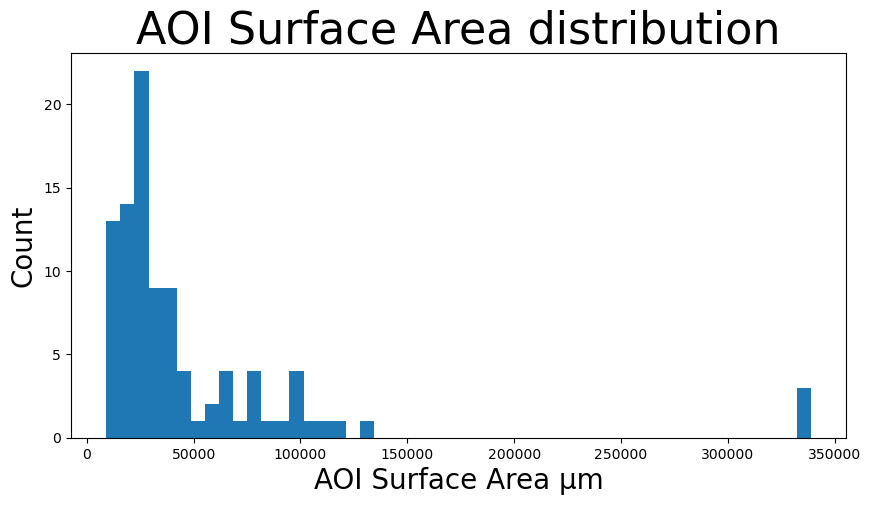

In [44]:
# View distribution of AOI surface areas

#Add colouring for different AOI types

SAHist = plot_SA_Hist(surfArea)
# SAHist.show()

<BarContainer object of 96 artists>

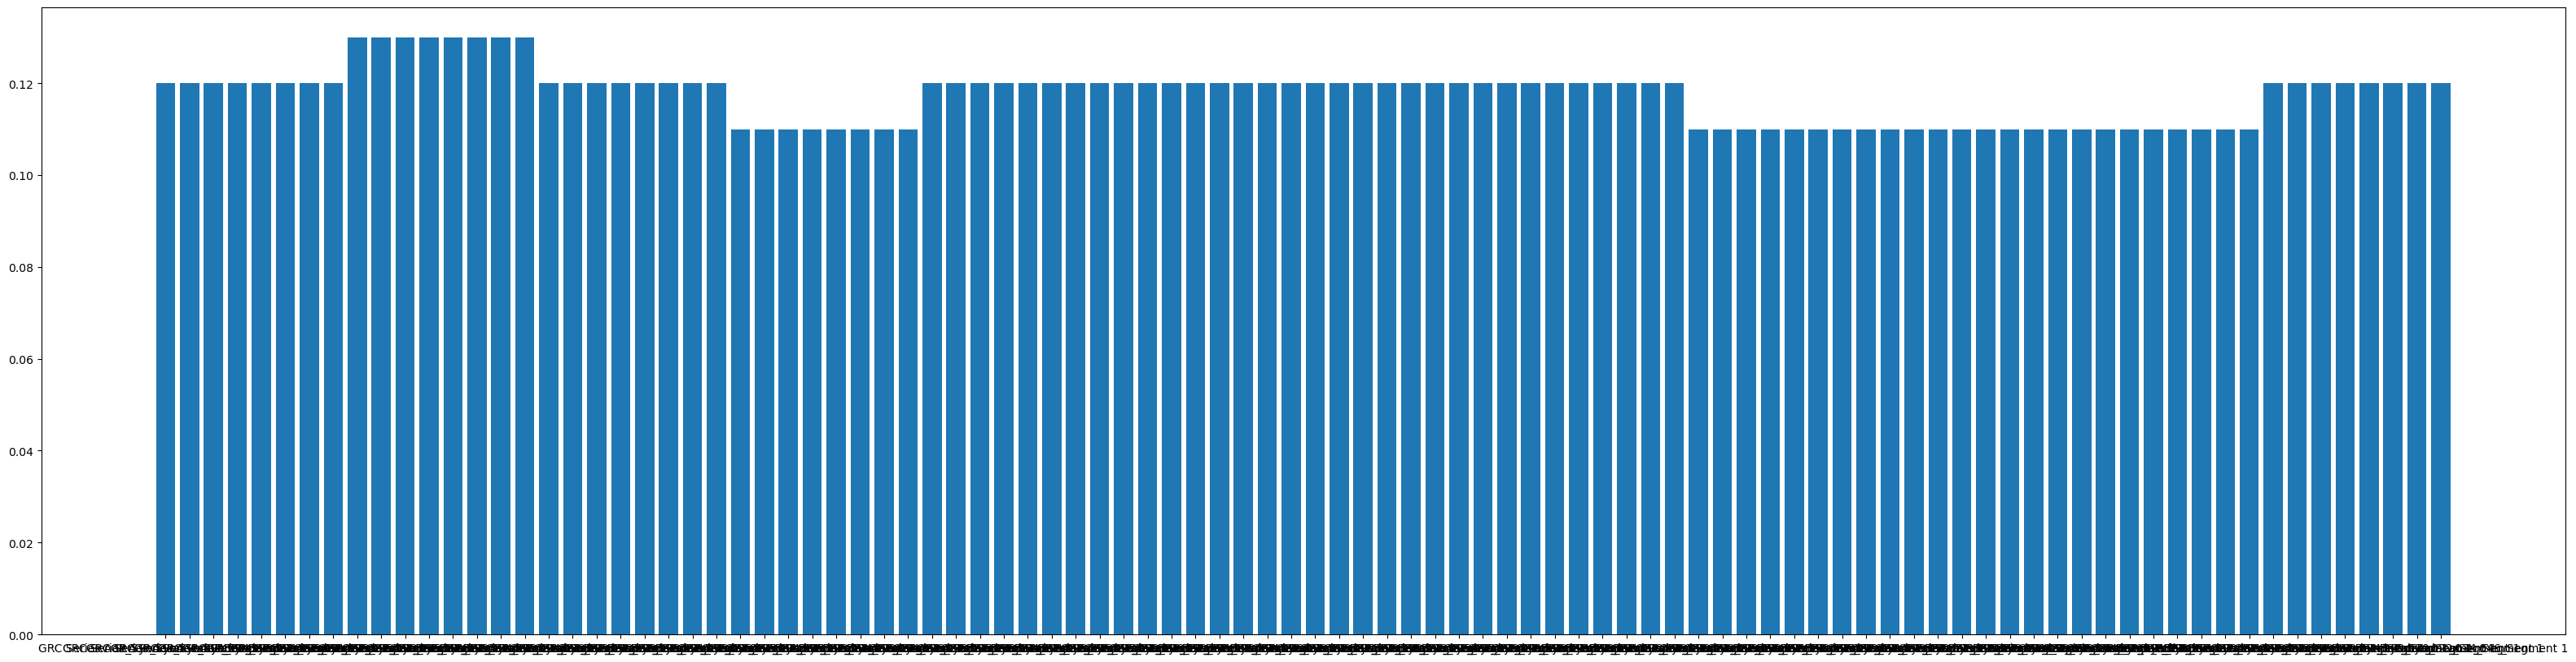

In [45]:
# sampleInfoExternal.sort_values(by=['plate', 'plateCol', 'plateRow'], axis=1, inplace=True)
sampleInfoExternal.sort_values(by=['Plate', 'Col', 'Row'], axis=1, inplace=True)

# Binding Density plot:
plt.figure(figsize=(40,10))
    
# plt.bar(sampleInfoExternal.columns[:40],sampleInfoExternal.loc['BindingDensity'].values.astype(np.float32)[:40])#, bottom=0)
plt.bar(sampleInfoExternal.columns,sampleInfoExternal.loc['BindingDensity'].values.astype(np.float32))#, bottom=0)
# plt.ylim(0,20)

In [46]:
# Visualise basic QC statistics

## Relate back to collection order, and plate/well location

## Binding density

In [47]:
# sampleInfoExternal.loc['BindingDensity'].values.astype(np.float32)

# Visualise raw probe values before any normalisation

29
29
29
29


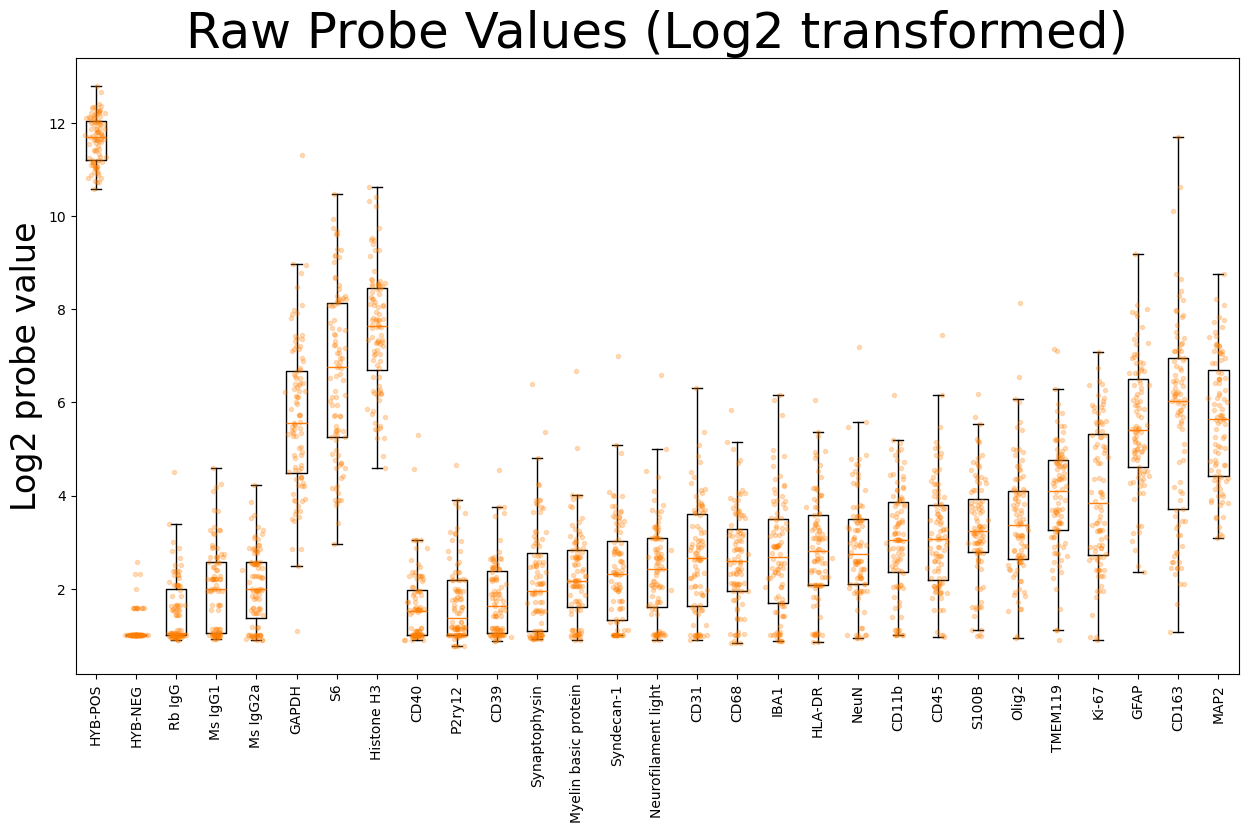

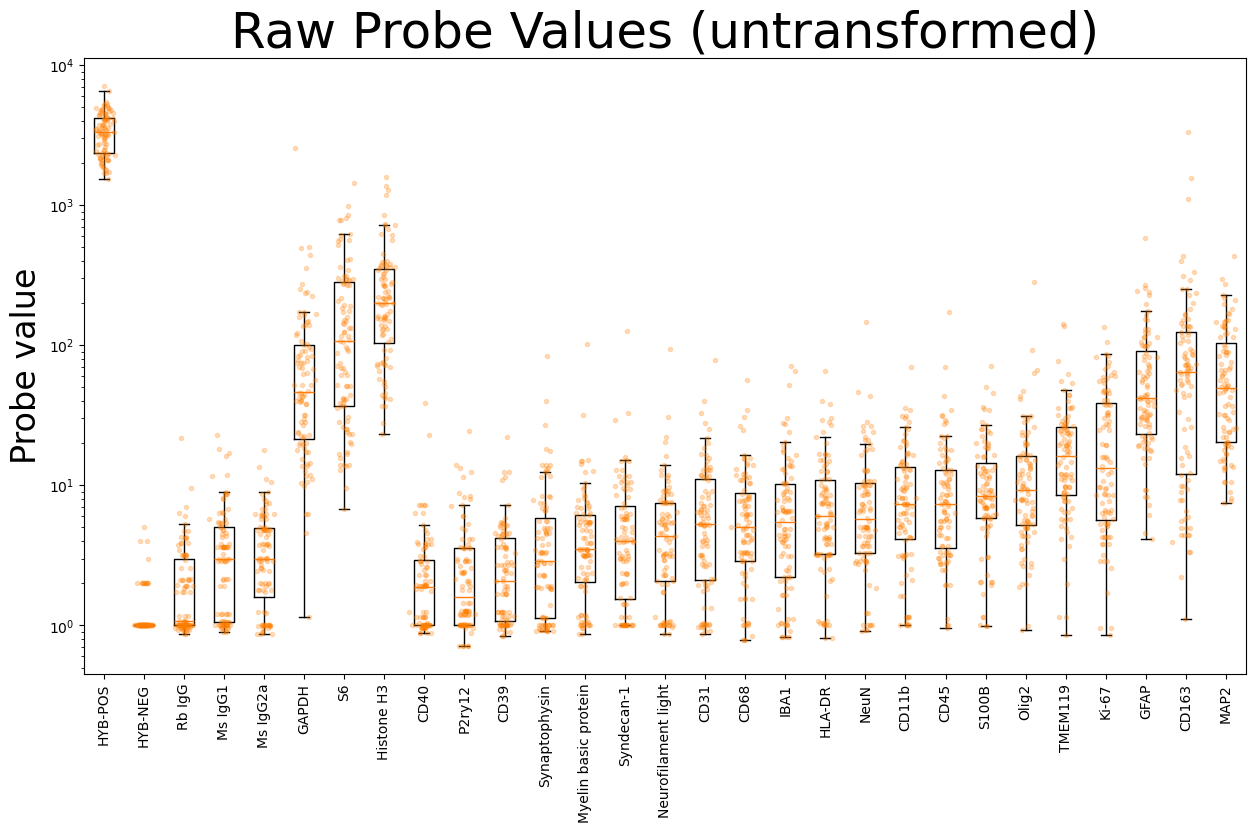

In [48]:
# Sort data by probeclass then mean for nicer visualisation on plots
dataSortedRaw = dataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

probePlot = draw_probe_plot(dataLog1External, dataSortedRaw, namedColourList, 'Raw Probe Values')
probePlot = draw_probe_plot(dataLog1External, dataSortedRaw, namedColourList, 'Raw Probe Values', exp=True)

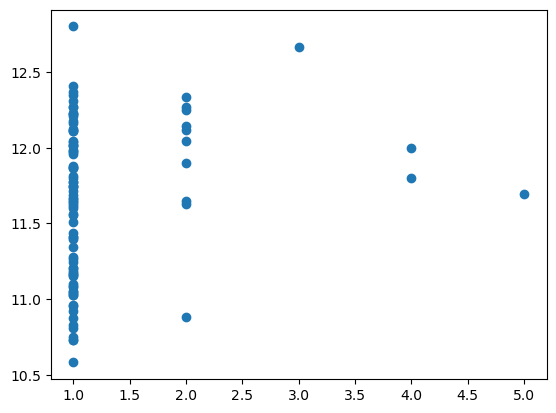

In [49]:
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
            dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-POS'])

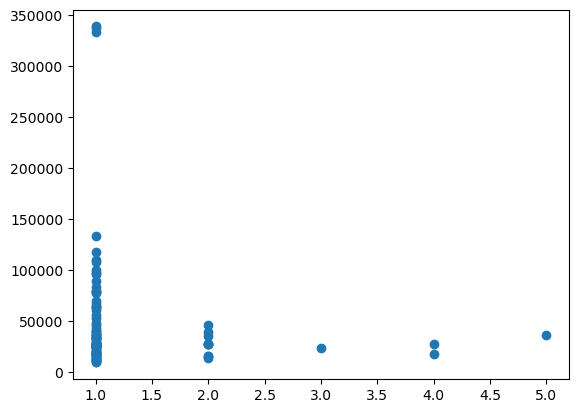

In [50]:
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
        surfArea.reindex(dataLog1External.drop(labels=['mean','probeClass'],axis=1).columns))

In [51]:
##### QC questions / checks:

# Determine thresholding value for limit of detection for assay

In [52]:
## Find the first local minimum closest to the start of the 'real' values.
## In this development case there is a large peak of near zero values, after this there are two bins with zero values. The second of these bin indexes was chosen for use as the expression threshold value.


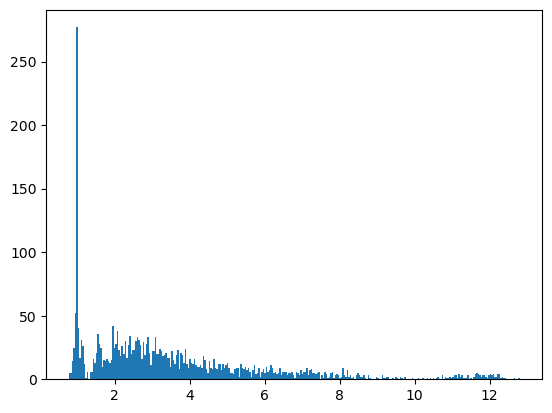

In [53]:
thresholding = threshold_probes(dataLog1External, 300)

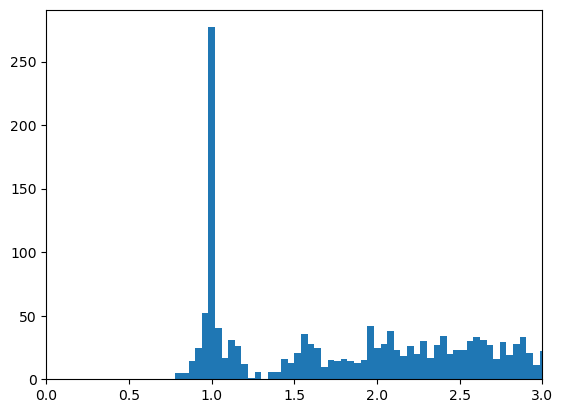

In [54]:
thresholding.zoom_plot(0.5,3)

In [55]:
thresholding.check_threshold(0,20)
thresholding.check_threshold(10,20)

[  5.   5.  14.  25.  52. 277.  40.  17.  31.  26.  12.   1.   6.   0.
   6.   6.  16.  13.  21.  36.]
[0.77966017 0.81972998 0.8597998  0.89986962 0.93993944 0.98000926
 1.02007914 1.06014895 1.10021877 1.14028859 1.18035841 1.22042823
 1.26049805 1.30056787 1.34063768 1.3807075  1.42077732 1.46084714
 1.50091696 1.54098678]
[12.  1.  6.  0.  6.  6. 16. 13. 21. 36.]
[1.18035841 1.22042823 1.26049805 1.30056787 1.34063768 1.3807075
 1.42077732 1.46084714 1.50091696 1.54098678]


In [56]:
#Set index value to use for minimum expression threshold from thresholding 
thresholding.set_threshold_idx(13)

0.0
1.300567865371704


In [57]:
print(thresholding.threshold)
ETFiltered = thresholding.get_filter()

1.300567865371704


# Plot counts of AOIs and probes passing threshold

In [58]:


# get counts of how many probes are above the expression threshold for each AOI

In [59]:
exportPath = dataPath[:dataPath.rfind('/')]

In [60]:
ETFiltered

,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1,...,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1
Syndecan-1,True,False,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
CD31,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Ms IgG2a,True,False,True,True,True,True,False,False,False,False,...,True,True,True,True,True,False,False,True,True,False
S6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Olig2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Neurofilament light,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
IBA1,True,False,True,False,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
NeuN,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
HLA-DR,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
HYB-NEG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


thisMin
12
thisMax
29


[]

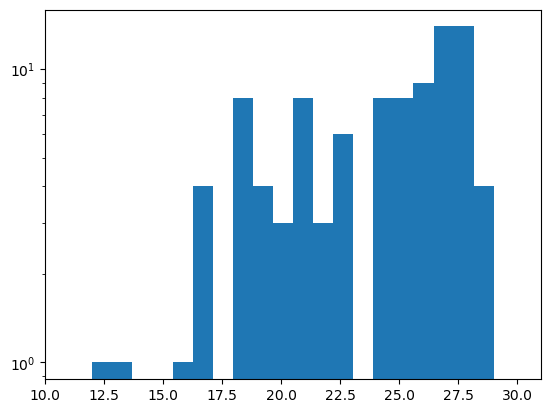

In [61]:
passAOI = ETFiltered.sum()

thisMin = min(passAOI)
thisMax = max(passAOI)
print('thisMin')
print(thisMin)
print('thisMax')
print(thisMax)

plt.hist(passAOI.values, bins=20)
plt.xlim(thisMin-2,thisMax+2)
plt.semilogy()

In [62]:
passAOI.sort_values().index[:5]

Index(['GRC Series A IP_Syndecan-1_102_Segment 1',
       'GRC Series A IP_Syndecan-1_222_Segment 1',
       'GRC Series A IP_Syndecan-1_010_Segment 1',
       'GRC Series A IP_Syndecan-1_013_Segment 1',
       'GRC Series B IP_Syndecan-1_045_Segment 1'],
      dtype='object')

In [63]:
failAOIs = passAOI[passAOI < 15]

failAOIs

GRC Series A IP_Syndecan-1_102_Segment 1    12
GRC Series A IP_Syndecan-1_222_Segment 1    13
dtype: int64

In [64]:
failAOIs.to_csv(os.path.join(exportPath,'failAOIs.csv'))


In [65]:
# get counts of how many AOIs are above the expression threshold for each probe

thisMin
14
thisMax
96


(9.0, 101.0)

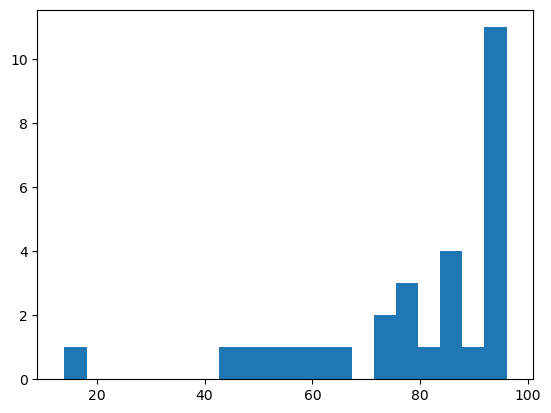

In [66]:
passProbe = ETFiltered.sum(axis=1)

thisMin = min(passProbe)
thisMax = max(passProbe)
print('thisMin')
print(thisMin)
print('thisMax')
print(thisMax)

plt.hist(passProbe.values, bins=20)
plt.xlim(thisMin-5,thisMax+5)
# plt.semilogy()

In [67]:
# ToDo: Ask for a value to use for fail probes cutoff

In [68]:
failProbes = passProbe[passProbe < 70]

failProbes

HYB-NEG          14
CD40             51
Synaptophysin    67
Rb IgG           44
CD39             58
Ms IgG1          60
P2ry12           48
dtype: int64

In [69]:
failProbes.to_csv(os.path.join(exportPath,'FailProbes.csv'))


In [70]:
master_data.set_threshold(master_data,ETFiltered)

In [71]:
master_data.threshold


,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1,...,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1
Syndecan-1,True,False,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
CD31,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Ms IgG2a,True,False,True,True,True,True,False,False,False,False,...,True,True,True,True,True,False,False,True,True,False
S6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Olig2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Neurofilament light,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
IBA1,True,False,True,False,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
NeuN,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
HLA-DR,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
HYB-NEG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [72]:
# Identify outlier AOIs and probes
# Drop outlier AOIs and probes

In [73]:
# colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' if x.split('_')[-1] == 'Immune' else 'purple' for x in data.drop(labels=['mean','probeClass'], axis=1).columns]


# Plot geometric means of negative controls and housekeeping genes in raw data:

In [74]:
##### It's probably not neccessary to view the following, 
# but lets just have a quick look at how the control values 
# for the raw data is distributed to make sure there are 
# no extreme outliers before ERCC normalisation.

In [75]:
# Calculate Ig control Geometric mean and Housekeeping gene Geometric mean
# Calculating the mean of log transformed data is analagous to calculating the geometric mean of the non-transformed data

HKGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc[masterData.HK].mean()
HKGeoMean = HKGeoMean.sort_values()


IgGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[masterData.IgCTLs].mean()

HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)

HKIgCtlGeoMeans = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[HKIgCtls].mean()


In [76]:
masterData.HK

['S6', 'Histone H3', 'GAPDH']

In [77]:
HKIgCtls = masterData.HK.copy()

In [78]:
HKIgCtls.extend(masterData.IgCTLs)

In [79]:
HKIgCtls

['S6', 'Histone H3', 'GAPDH', 'Ms IgG2a', 'Rb IgG', 'Ms IgG1']

In [80]:
HKGeoMean

GRC Series A IP_Syndecan-1_222_Segment 1     3.424838
GRC Series A IP_Syndecan-1_213_Segment 1     3.860932
GRC Series A IP_Syndecan-1_001_Segment 1     4.056308
GRC Series A IP_Syndecan-1_010_Segment 1     4.067630
GRC Series B IP_Syndecan-1_032_Segment 1     4.261097
                                              ...    
GRC Series B IP_Syndecan-1_008_Segment 1     9.206640
GRC Series A IP_Syndecan-1_103_Segment 1     9.372058
GRC Series B IP_Syndecan-1_036_Segment 1     9.547501
GRC Series A IP_Syndecan-1_241_Segment 1     9.574978
GRC Series B IP_Syndecan-1_006_Segment 1    10.427917
Length: 96, dtype: float32

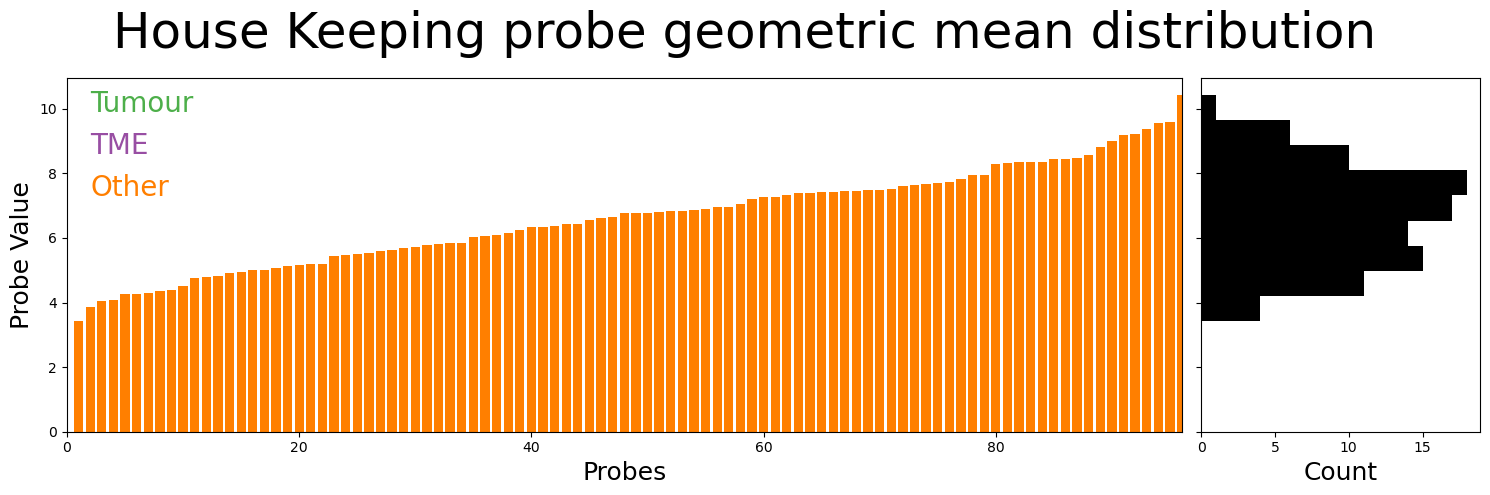

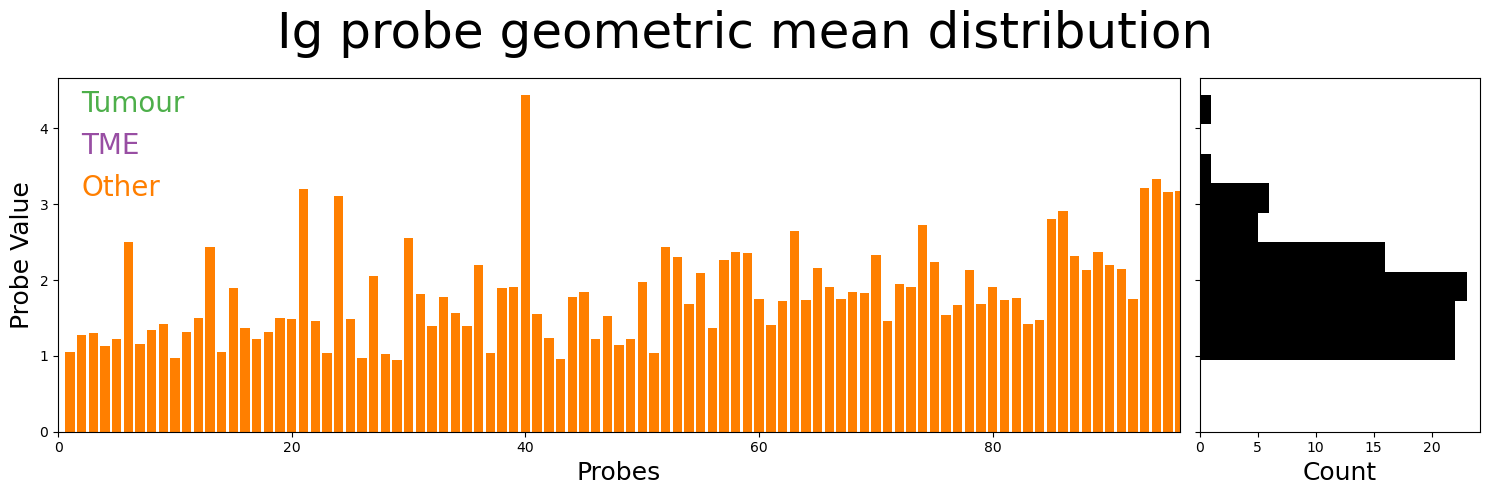

In [81]:
probe_GeoMean_Plots(HKGeoMean, 'House Keeping probe geometric mean distribution')

probe_GeoMean_Plots(IgGeoMean, 'Ig probe geometric mean distribution')

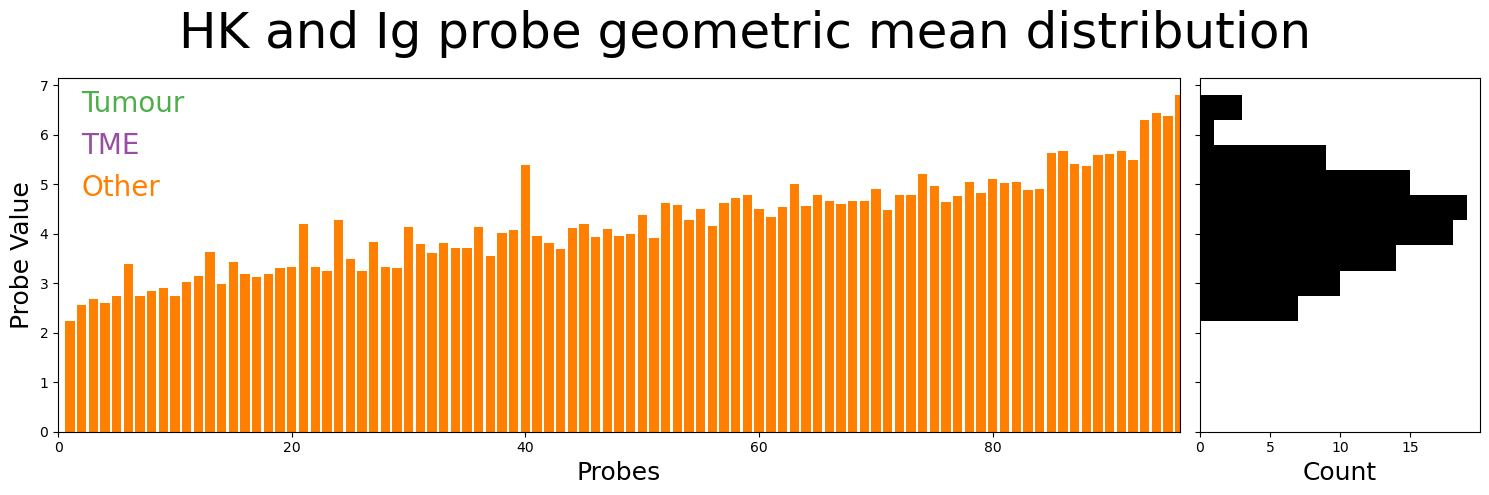

In [82]:
probe_GeoMean_Plots(HKIgCtlGeoMeans, 'HK and Ig probe geometric mean distribution')

In [83]:
HKIgCtls = masterData.HK.extend(masterData.IgCTLs)

In [84]:
masterData.HK

['S6', 'Histone H3', 'GAPDH', 'Ms IgG2a', 'Rb IgG', 'Ms IgG1']

In [85]:
#ToDo: make this a copy of the internal dataFrame. Ensure original data is contained in the master class and cannot be changed accidentally from outside of class.

ERCC_normExternal = masterData.ERCC_norm()

In [86]:
ERCC_normExternal

,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1,...,GRC Series A IP_Syndecan-1_241_Segment 1,GRC Series A IP_Syndecan-1_242_Segment 1,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1
Syndecan-1,2.487073,0.000000,1.845688,2.331750,0.000000,2.910306,2.174232,2.574002,0.000000,3.862607,...,3.092612,3.531918,2.826033,2.615923,2.852074,3.983875,2.657689,3.497863,2.614095,2.372556
CD31,2.657462,3.137025,2.082024,1.909567,2.430285,3.934600,3.108660,4.632058,2.224756,2.574656,...,3.334804,4.283256,3.743159,4.045932,4.076979,4.696609,3.441744,4.080833,1.499499,1.453497
Ms IgG2a,1.440145,0.000000,1.838187,2.247779,1.385044,3.278487,0.000000,0.000000,0.000000,0.000000,...,2.481339,3.143806,2.179288,2.046589,2.721453,0.000000,0.000000,2.525766,1.694078,0.000000
S6,7.590513,6.819535,7.381675,6.717935,6.504661,10.632936,8.740998,9.070379,7.443534,8.690186,...,9.259669,8.999441,8.057259,8.026655,9.005564,10.075317,9.572795,9.022645,7.095832,6.710130
Olig2,4.003591,2.791393,3.068940,2.094769,2.470046,5.021558,3.954385,5.014493,3.504338,3.240426,...,4.573554,4.248000,4.259076,3.957607,4.517709,4.832122,5.531602,4.854350,2.947822,3.392200
Neurofilament light,2.857235,2.694068,1.313359,0.000000,1.591340,4.668979,2.494273,3.219151,2.205279,2.552843,...,3.195026,2.237111,3.263374,2.360235,3.824603,3.479392,3.883508,2.532153,2.714534,2.610423
IBA1,3.129724,0.000000,1.374262,0.000000,2.849960,4.380424,2.891745,2.534594,0.000000,3.444210,...,3.164796,2.877295,3.750930,3.403294,4.217482,4.533464,3.957925,3.159257,1.540925,1.829155
NeuN,2.228667,2.625667,1.919303,3.108924,0.000000,4.523705,3.517770,3.917539,2.811223,2.299180,...,4.319577,3.441218,4.396674,3.233663,4.275741,4.468193,4.112570,4.296692,0.000000,2.826678
HLA-DR,3.467114,2.314621,1.944522,2.098564,2.643025,5.116233,2.263426,4.967649,0.000000,3.101321,...,4.445301,3.455398,3.625188,4.189946,4.258062,4.672589,4.562207,3.114119,3.479825,2.681525
HYB-NEG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Load in deafult QC data for further data QC

In [87]:
configDict['QCDataPath']

'/Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/DSP_Protein_Data/Default_QC.xlsx'

In [88]:
dataPath = configDict['QCDataPath']

QCmasterData = master_data(dataPath)
QCdataLog1External, QCsampleInfoExternal = QCmasterData.get_data()

# For the Thomas TMA study there are a number of additional AOIs to be used for data normalisation studies.
# These should be removed before further data analysis and QC.

print(QCmasterData.probeClass)
print(QCmasterData.probeClassDict)
# dataLog1External, sampleInfoExternal = masterData.drop_AOIs('#16_9', writeOrig=True)

QCnuclei = QCsampleInfoExternal.loc['AOI nuclei count']
QCsurfArea = QCsampleInfoExternal.loc['AOI surface area']

QCdataLog1External, QCsampleInfoExternal = QCmasterData.add_class_mean(QCmasterData.dataLog1)

sampleInfo.shape
(29, 96)
data.shape
(27, 96)
Syndecan-1              Endogenous
CD31                    Endogenous
Ms IgG2a                  Negative
S6                         Control
Olig2                   Endogenous
Neurofilament light     Endogenous
IBA1                    Endogenous
NeuN                    Endogenous
HLA-DR                  Endogenous
CD163                   Endogenous
Histone H3                 Control
TMEM119                 Endogenous
GFAP                    Endogenous
GAPDH                      Control
MAP2                    Endogenous
CD40                    Endogenous
Myelin basic protein    Endogenous
Synaptophysin           Endogenous
CD11b                   Endogenous
CD68                    Endogenous
Rb IgG                    Negative
CD39                    Endogenous
Ms IgG1                   Negative
Ki-67                   Endogenous
P2ry12                  Endogenous
CD45                    Endogenous
S100B                   Endogenous
Name: Pro

/Users/upton6/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [89]:
dataLog1External

,GRC Series B IP_Syndecan-1_001_Segment 1,GRC Series B IP_Syndecan-1_002_Segment 1,GRC Series B IP_Syndecan-1_003_Segment 1,GRC Series B IP_Syndecan-1_004_Segment 1,GRC Series B IP_Syndecan-1_005_Segment 1,GRC Series B IP_Syndecan-1_006_Segment 1,GRC Series B IP_Syndecan-1_007_Segment 1,GRC Series B IP_Syndecan-1_008_Segment 1,GRC Series B IP_Syndecan-1_009_Segment 1,GRC Series B IP_Syndecan-1_010_Segment 1,...,GRC Series A IP_Syndecan-1_243_Segment 1,GRC Series A IP_Syndecan-1_251_Segment 1,GRC Series A IP_Syndecan-1_252_Segment 1,GRC Series A IP_Syndecan-1_253_Segment 1,GRC Series A IP_Syndecan-1_261_Segment 1,GRC Series A IP_Syndecan-1_262_Segment 1,GRC Series A IP_Syndecan-1_263_Segment 1,GRC Series A IP_Syndecan-1_264_Segment 1,mean,probeClass
Syndecan-1,2.492548,1.108978,2.160528,2.492548,1.108978,2.762272,1.728511,1.728511,1.108978,3.358315,...,3.211209,2.359137,2.359137,3.076411,2.105847,2.761899,2.762272,2.989424,2.354208,E
CD31,2.662938,3.081766,2.396864,2.070365,2.887497,3.786566,2.662938,3.786566,1.647676,2.070365,...,4.128336,3.789145,3.584042,3.789145,2.889902,3.344869,1.647676,2.070365,2.636701,E
Ms IgG2a,1.445621,0.896776,2.153028,2.408576,1.842255,3.130454,1.000000,1.000000,0.896776,0.896776,...,2.564464,1.789803,2.228515,1.156292,1.000000,1.789803,1.842255,1.000000,2.036412,B
S6,7.595989,6.764277,7.696515,6.878733,6.961872,10.484903,8.295277,8.224888,6.866455,8.185894,...,8.442435,7.769869,8.512627,9.167853,9.020953,8.286681,7.244009,7.326998,6.633258,C
Olig2,4.009067,2.736135,3.383780,2.255567,2.927258,4.873525,3.508663,4.169002,2.927258,2.736135,...,4.644252,3.700821,4.024772,3.924658,4.979760,4.118386,3.095998,4.009067,3.447328,E
Neurofilament light,2.862711,2.638809,1.628199,1.032548,2.048551,4.520946,2.048551,2.373659,1.628199,2.048551,...,3.648551,2.103449,3.331666,2.571928,3.331666,1.796189,2.862711,3.227291,2.386716,E
IBA1,3.135200,1.078801,1.689102,1.078801,3.307172,4.232390,2.446023,1.689102,1.000000,2.939918,...,4.136107,3.146507,3.724545,3.626000,3.406083,2.423293,1.689102,2.446023,2.709409,E
NeuN,2.234143,2.570408,2.234143,3.269722,1.160238,4.375672,3.072048,3.072048,2.234143,1.794889,...,4.781851,2.976876,3.782804,3.560729,3.560729,3.560729,1.160238,3.443547,2.891703,E
HLA-DR,3.472591,2.259362,2.259362,2.259362,3.100237,4.968200,1.817704,4.122158,1.000000,2.597030,...,4.010365,3.933160,3.765125,3.765125,4.010365,2.378155,3.628003,3.298393,2.859851,E
HYB-NEG,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.115400,B


ToDo: Collate figures into a pdf

In [90]:
# Sort data by probeclass then mean for nicer visualisation on plots
QCdataSortedERCC = QCdataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

# ToDo: repeat the colour map after data sorting


27
27
27
27
27
27


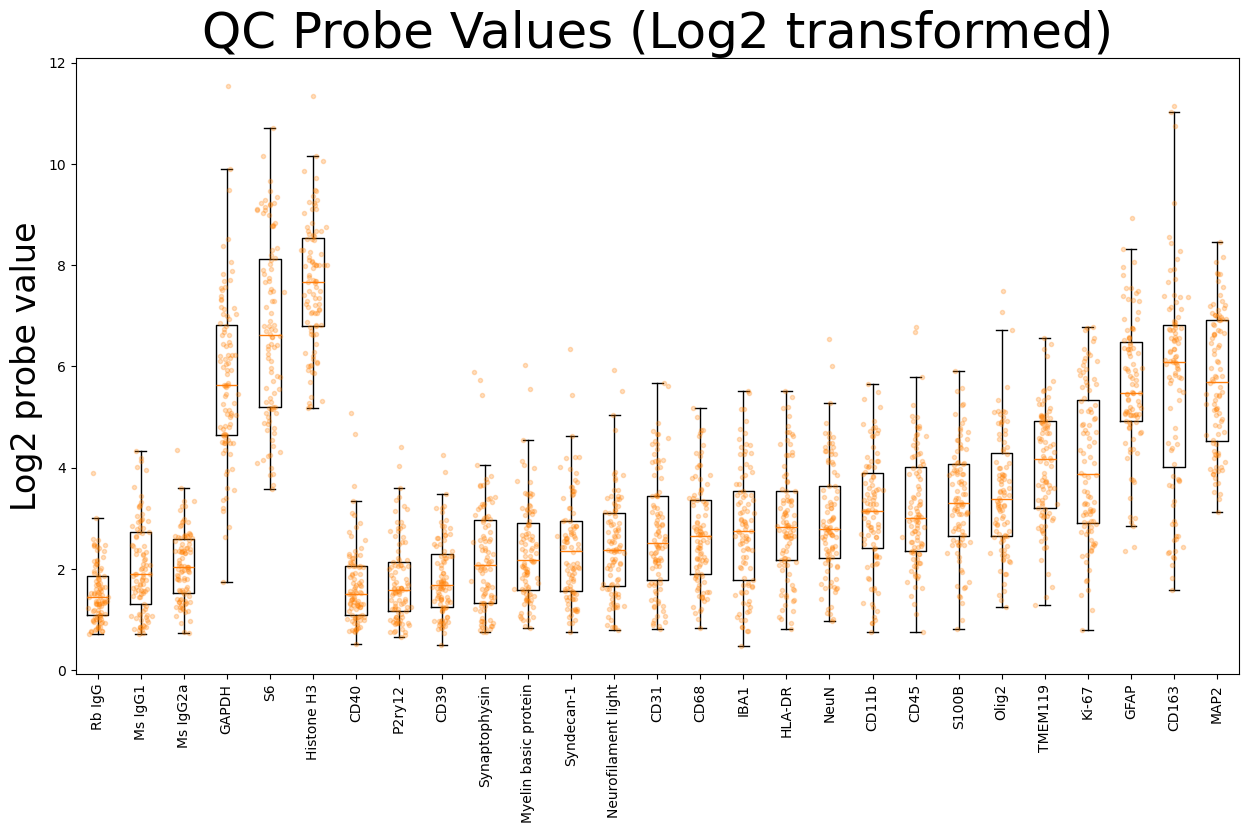

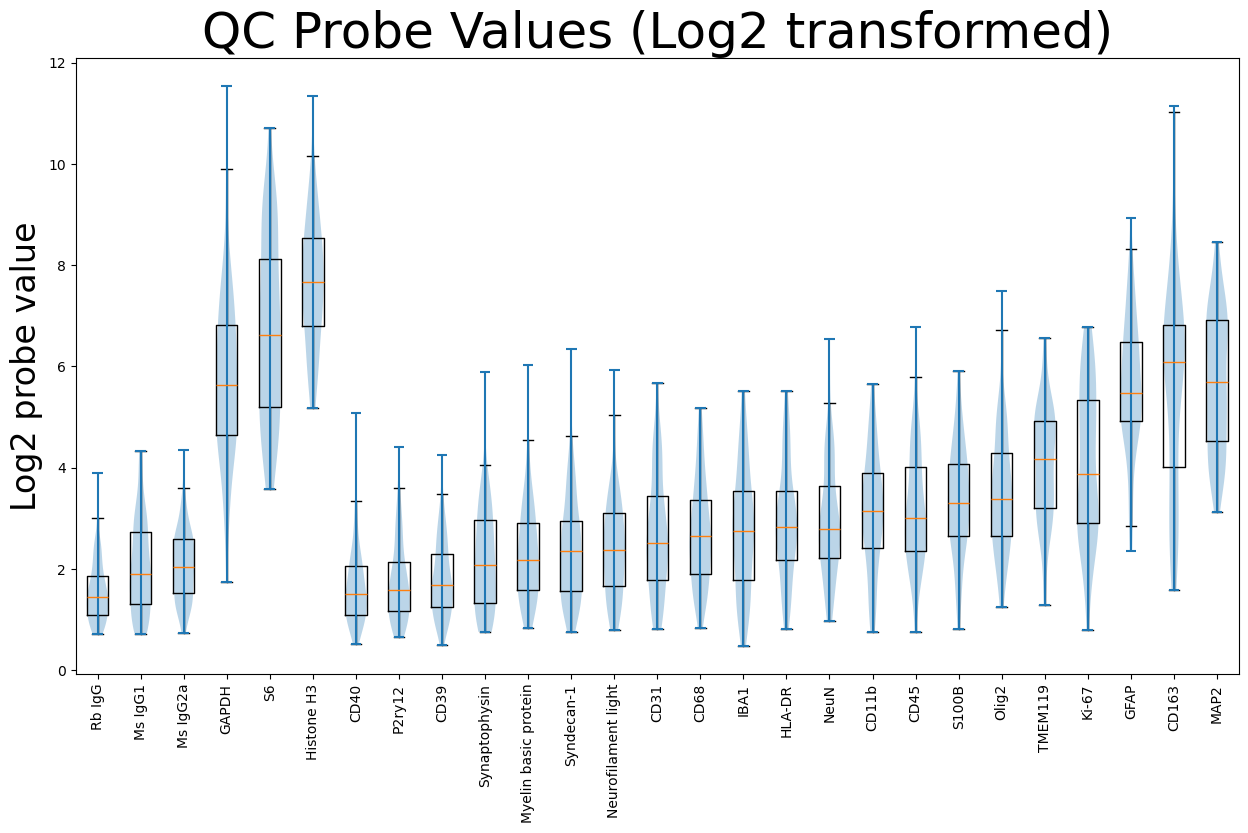

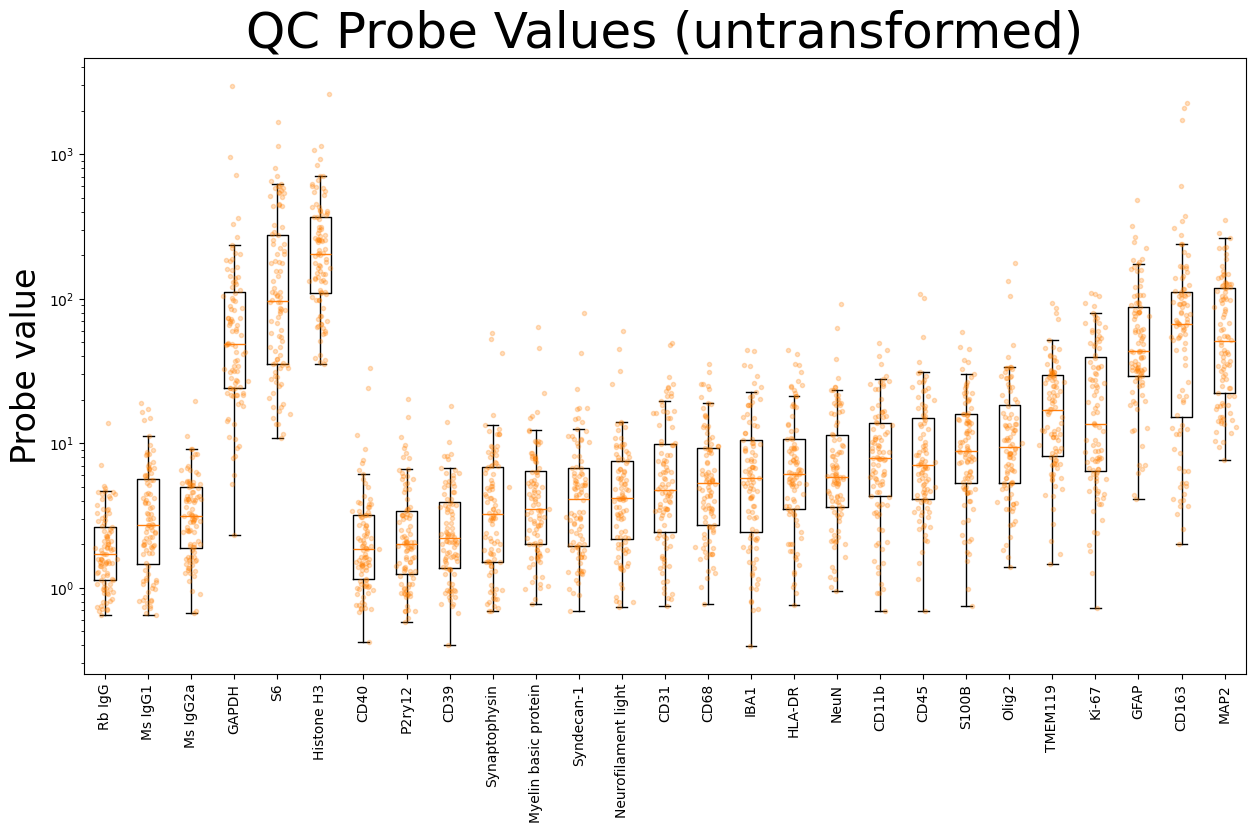

In [91]:
# ToDo make sure hyb pos has been dropped propperly


probePlot = draw_probe_plot(QCdataLog1External, QCdataSortedERCC, namedColourList, 'QC Probe Values')
probePlot = draw_probe_plot(QCdataLog1External, QCdataSortedERCC, namedColourList, 'QC Probe Values', violin=True)

probePlot = draw_probe_plot(QCdataLog1External, QCdataSortedERCC, namedColourList, 'QC Probe Values', exp=True)

In [92]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Work on heatmap plots with clustering trees and labels / colour legends

In [ ]:
# plt.matshow(ERCC_normExternal)

In [ ]:
# plt.matshow(QCdataLog1External.drop(labels=['mean','probeClass'], axis=1))

In [ ]:
# QCdataLog1External

In [ ]:
# plt.matshow(QCdataLog1External.drop(labels=['mean','probeClass'], axis=1) - ERCC_normExternal)

In [ ]:
ERCC_normExternal, ignore = masterData.add_class_mean(masterData.ERCCData)


In [ ]:
# Sort data by probeclass then mean for nicer visualisation on plots
dataSortedERCC = ERCC_normExternal.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

# ToDo: repeat the colour map after data sorting


In [ ]:
dataSortedERCC

In [ ]:
# ToDo make sure hyb pos has been dropped propperly


probePlot = draw_probe_plot(ERCC_normExternal, dataSortedERCC, namedColourList, 'ERCC Probe Values')
probePlot = draw_probe_plot(ERCC_normExternal, dataSortedERCC, namedColourList, 'ERCC Probe Values', violin=True)

probePlot = draw_probe_plot(ERCC_normExternal, dataSortedERCC, namedColourList, 'ERCC Probe Values', exp=True)

In [ ]:
# ToDo: Move this to the master function


# Calculate Ig control Geometric mean and Housekeeping gene Geometric mean
# Calculating the mean of log transformed data is analagous to calculating the geometric mean of the non-transformed data

HKGeoMean = ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).loc[masterData.HK].mean()
HKGeoMean = HKGeoMean.sort_values()

IgGeoMean = ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[masterData.IgCTLs].mean()



HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)
HKIgCtlGeoMeans = ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[HKIgCtls].mean()




In [ ]:
probe_GeoMean_Plots(HKGeoMean, 'House Keeping probe geometric mean distribution')
probe_GeoMean_Plots(IgGeoMean, 'Ig probe geometric mean distribution')

In [ ]:
probe_GeoMean_Plots(HKIgCtlGeoMeans, 'HK and Ig probe geometric mean distribution')

In [ ]:
# Include negative scaled analysis? Could be used to show low expressed values??


negScaled = ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1) - IgGeoMean + IgGeoMean.mean()

mean = negScaled.mean(axis = 1)
negScaled = negScaled.assign(mean=mean.values)

negScaled = negScaled.assign(probeClass=ERCC_normExternal['probeClass'].values)

negScaled.sort_values(by = ['probeClass', 'mean'], ascending=[True,True] , inplace=True)

# Log2 Signal-to-Background Ratio
plt.figure(figsize=(20,10))

plt.boxplot(negScaled.drop(labels=['mean','probeClass'], axis=1).T, sym='.', labels=negScaled.index)
plt.violinplot(negScaled.drop(labels=['mean','probeClass'], axis=1).T)
plt.xticks(rotation = 90)
# plt.axhline(y=0.0, color='r', linestyle='-')

plt.title('Ig Control Scaled Probe Values (Log2 transformed)', size=36)
plt.ylabel('Log2 probe value', size=24)
plt.show()
plt.close()


In [ ]:
# Add plot of number of samples fall below expression threshold for Ig control scaled data??

In [ ]:
#### Don't put too much stock in this plot. The data has been scaled to the Ig negative controls. BUT Nanopore say that some probes have a consistently low signal so probes with a signal below the Ig level can still be reliable 

In [ ]:
## Plot control scatter plots and choose factors for further normalisation

In [ ]:
# colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' for x in data.drop(labels=['mean','probeClass'], axis=1).columns]
# colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' if x.split('_')[-1] == 'Immune' else 'purple' for x in data.drop(labels=['mean','probeClass'], axis=1).columns]
colours = [namedColourList[2] if x.split('_')[-1] == 'Tumour' else namedColourList[5] if x.split('_')[-1] == 'TME' else namedColourList[1] for x in ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).columns]



In [ ]:
def matrix_plot(plotData, labels, dataList=False):
    ###
# Matrix of HK expression plots
    rows = len(labels)
    cols = len(labels)

    fig, axes = plt.subplots(rows,cols, figsize=(15,15))

    if dataList:
        dataList = plotData
    else:
        dataList = []
        for feat in labels:
            dataList.append([(x) for x in plotData.drop(labels=['mean','probeClass'], axis=1).loc[feat].values])
        
    axMin = int(min([min(x) for x in dataList]))
    axMax = int(max([max(x) for x in dataList]))+1

    for r in range(rows):
        for c in range(cols):
            if r==c: # This is a diagonal, insert a label
                axes[r][c].text(0.5,0.5, labels[r],ha='center', va='center', transform=axes[r][c].transAxes,fontsize=36)
            else:
                axes[r][c].scatter(dataList[c], dataList[r], c=colours)
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataList[c], dataList[r])
                axes[r][c].text(0.9,0.9, "r_value = " + str(r_value)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
                axes[r][c].text(0.9,0.8, "slope = " + str(slope)[:5],ha='right', va='center', transform=axes[r][c].transAxes)
                axes[r][c].set_xlim(axMin,axMax)
                axes[r][c].set_ylim(axMin,axMax)



In [ ]:
matrix_plot(ERCC_normExternal, ['S6', 'Histone H3', 'GAPDH'])

In [ ]:
matrix_plot(ERCC_normExternal, ['Ms IgG1', 'Ms IgG2a', 'Rb IgG'])

In [ ]:
min(HKGeoMean)

In [ ]:
min(IgGeoMean)

In [ ]:
np.log2(list(surfArea.values+1))

In [ ]:
nuclei = nuclei.reindex(HKGeoMean.index)
surfArea = surfArea.reindex(HKGeoMean.index)





dataList = [HKGeoMean, IgGeoMean, np.log2(list(surfArea.values)), np.log2(list(nuclei.values+1))]




matrix_plot(dataList, ['HKGMean', 'IgGMean', 'Area', 'Nuclei'], True)

In [ ]:
#drop least consistent controls and repeat plots
# IgCTLs.remove('Ms IgG2a')
# HK.remove('Histone H3')


#Nothiong to remove for Thomas_TMA run


In [ ]:
ERCC_normExternal

In [ ]:
HKNormData = (ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).reindex(labels=negScaled.index) - HKGeoMean)

print(min((HKNormData).values.flatten()))
print(min((HKNormData).loc['HYB-NEG'].values.flatten()))
print(min((HKNormData.drop(labels=['HYB-NEG'])).values.flatten()))

print(min((HKNormData*ETFiltered).values.flatten()))
print(min((HKNormData*ETFiltered).loc['HYB-NEG'].values.flatten()))
print(min((HKNormData.drop(labels=['HYB-NEG'])*ETFiltered).values.flatten()))
#  + np.mean(HKGeoMean)

In [ ]:
HKNormData = HKNormData + (abs(min((HKNormData*ETFiltered).values.flatten())))
# HKNormData = HKNormData + (abs(min((HKNormData.drop(labels=['HYB-NEG'])*ETFiltered).values.flatten())))
# HKNormData = HKNormData + (abs(min((HKNormData.drop(labels=['HYB-NEG'])).values.flatten())))

# HKNormData = HKNormData * ETFiltered

In [ ]:
# Plot HK normalised data
plt.figure(figsize=(20,10))

# HKNormData = (ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).reindex(labels=negScaled.index) - HKGeoMean) + np.mean(HKGeoMean)

plt.boxplot(HKNormData.T, sym='-', labels=negScaled.index)

for i,j in enumerate(negScaled.index):
    y = HKNormData.loc[j]
#     colours = ['g.' if v.split('_')[-1] == 'Tumour' else 'r.' if v.split('_')[-1] == 'Immune' else 'b.' for v in y.index]
    colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'TME' else namedColourList[1] for v in y.index]
    
    y = y
    y = y.values
    x = np.random.normal(i+1, 0.1, len(y))
    
    for i in range(len(x)): 
        plt.plot(x[i], y[i], c=colours[i], marker='.')
plt.xticks(rotation = 90)
plt.axhline(y=0.0, color='r', linestyle='-')
    
plt.title('HK Normalised probe values (Log2 transformed)', size=36)
plt.ylabel('Log2 probe value', size=24)


In [ ]:
HKNormData = HKNormData * ETFiltered
HKNormData = HKNormData.reindex(negScaled.index)


In [ ]:
# Plot HK normalised data
plt.figure(figsize=(20,10))

# HKNormData = (ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).reindex(labels=negScaled.index) - HKGeoMean) + np.mean(HKGeoMean)

plt.boxplot(HKNormData.T, sym='-', labels=negScaled.index)

for i,j in enumerate(negScaled.index):
    y = HKNormData.loc[j]
#     colours = ['g.' if v.split('_')[-1] == 'Tumour' else 'r.' if v.split('_')[-1] == 'Immune' else 'b.' for v in y.index]
    colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'TME' else namedColourList[1] for v in y.index]
#     colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'Immune' else namedColourList[1] for v in y.index]
    
    y = y
    y = y.values
    x = np.random.normal(i+1, 0.1, len(y))
    
    for i in range(len(x)): 
        plt.plot(x[i], y[i], c=colours[i], marker='.')
plt.xticks(rotation = 90)
plt.axhline(y=0.0, color='r', linestyle='-')
    
plt.title('HK Normalised probe values (Log2 transformed)', size=36)
plt.ylabel('Log2 probe value', size=24)


In [ ]:
## ToDo: Calculations need to be updated to use method above!!


# # Plot negative probe normalised data
# plt.figure(figsize=(20,10))

# IgNormData = (ERCC_normExternal.drop(labels=['mean','probeClass'], axis=1).reindex(labels=negScaled.index) - IgGeoMean) + np.mean(IgGeoMean)


# plt.boxplot(IgNormData.T, sym='.', labels=negScaled.index)

# for i,j in enumerate(negScaled.index):
#     y = IgNormData.loc[j]
#     colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'Immune' else namedColourList[1] for v in y.index]
#     y = y
#     y = y.values
#     x = np.random.normal(i+1, 0.1, len(y))
    
#     for i in range(len(x)): 
#         plt.plot(x[i], y[i], c=colours[i], marker='.')
# plt.xticks(rotation = 90)
# plt.axhline(y=0.0, color='r', linestyle='-')
# plt.xlabel=list(negScaled.index)
    
# plt.title('Ig Normalised probe values (Log2 transformed)', size=36)
# plt.ylabel('Log2 probe value', size=24)


In [ ]:
# # ToDo: Repeat normalisation from master data then export.

# ercc normalise
# HK normalise

In [ ]:
break

In [ ]:
# Drop control probe values from negScaled to generate index for exporting. HYB-POS has already been dropped.

exportIndex = negScaled.drop(labels=['HYB-POS', 'HYB-NEG', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']).index
# exportIndex = negScaled.drop(labels=['HYB-NEG', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']).index
# exportIndex = negScaled.drop(labels=['HYB-NEG', 'Rb IgG', 'Ms IgG2a', 'Rt IgG2b']).index

In [ ]:
len(exportIndex)

In [ ]:
exportIndex

In [ ]:
HKNormData.reindex(labels=exportIndex)

In [ ]:
# exportPath = '../../../Documents/Nanostring/projects/Indira/DSP_Protein_Data/'
exportPath = dataPath[:dataPath.rfind('/')]

In [ ]:
exportPath

In [ ]:
HKNormData.reindex(labels=exportIndex).to_csv(os.path.join(exportPath,'HK_Geo_Mean_Normalised.csv'))
ETFiltered.reindex(labels=exportIndex).to_csv(os.path.join(exportPath,'Probe_Filter.csv'))

sampleInfoExternal.to_csv(os.path.join(exportPath,'Sample_Info.csv'))


In [ ]:
# # Export data scaled to HK Geo. mean and Ig Geo mean with outlier control probes dropped

# dataHKGMScaled = (dataFinal.reindex(labels=exportIndex) - HKGeoMean) + np.mean(HKGeoMean)
# dataHKGMScaled.to_csv('HK_Geo_Mean_Scaled.csv')

# dataIgGMScaled = (dataFinal.reindex(labels=exportIndex) - IgGeoMean) + np.mean(IgGeoMean)
# dataIgGMScaled.to_csv('Ig_Geo_Mean_Scaled.csv')

# sampleInfo.to_csv('Sample_Info.csv')

In [ ]:
# To Do:

### Generate new dataFrame with mask of where individual values are below HYB-NEG


### Generate new dataFrame with mask of where individual values are below NegGeoMean 
### Generate new dataFrame with mask of where mean value of a probe is below NegGeoMean 